In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import harmonypy as hm
import scipy.sparse as sp
import celltypist
from celltypist import models

In [2]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

import numba
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

Several lung datasets:

1. The `lung_hca_vieira.h5ad` dataset from the public reference, with 36,000 genes in `adata.var`. The data are normalized and log-transformed.

All lung cancer datasets from our internal database also contain 36,000 genes and were normalized similarly.

2. The `Lung_normal_new_filtered.h5ad` dataset contains normal lung tissue, taken from a separate study. Only annotated epithelial cells were retained. The data are normalized and log-transformed.

3. The `LUNG_SCLC_LUAD_Chan_2021_filtered.h5ad` dataset includes tumor epithelial cells (SCLC and LUAD). Only malignant epithelial cells were kept.

4. The `LUNG_GSE148071_LUAD_LUSC` dataset was added recently and includes LUAD and LUSC. The expression values were derived from log-normalized data.

Note: all datasets contain a different number of genes in `adata.var`.

After merging and normalization, it's recommended to store the `.raw` layer in `AnnData`, allowing future PCoA analysis on all genes, not just HVGs.

**Objective:**

- Revert normalized expression values to pseudo-counts in two datasets; leave raw values in the third.
- Identify shared genes across all three datasets and retain only those.
- Annotate the lung dataset separately.
- Carefully verify annotation consistency — identical cell types may be labeled differently.
- Merge all datasets and normalize to 10,000 counts per cell.
- Check cell and sample counts per cluster. Rare populations can be kept, but samples (batches) with too few cells should be excluded before HVG selection.

---

We have several lung datasets that need to be loaded and merged based on shared genes, followed by normalization and optional log-transformation (which may be skipped if pseudobulk is used).

**Steps:**
1. Generate UMAPs and Leiden clusters with cluster labels.
2. Create pseudobulk datasets grouped by sample and cell type:
   - Each pseudobulk = unique (sample, cell type) pair.
3. Perform PCA on pseudobulk profiles grouped by cell type.
4. Run PCoA using all genes:
   - Compute a distance matrix
   - Perform PCoA
5. Identify the top 7 or top 10 marker genes for each normal cell type:
   - Use the Wilcoxon test or `scanpy.tl.rank_genes_groups` with `method='wilcoxon'`.
6. Generate a high-quality heatmap.
7. Run PCoA again using only top marker genes per cell type.

Save top marker genes and top 100 DEGs for each normal lung cell type using only non-cancer samples.

We have several lung datasets. The plan is to load and merge them using shared genes,
normalize, and optionally log-transform (though this might be skipped if pseudobulk is used).

Steps:
1. Generate UMAP and Leiden clustering with cell type labels
2. Create pseudobulk profiles by sample and cell type:
   - Each pseudobulk = unique (sample, cell type) pair
3. Perform PCA across cell types using pseudobulk profiles
4. Run PCoA using all genes on pseudobulk profiles:
   - Compute distance matrix
   - Perform PCoA
5. Identify top 7–10 marker genes for each normal cell type:
   - Use Wilcoxon test or `scanpy.tl.rank_genes_groups` (with method='wilcoxon')
6. Plot heatmap
7. Repeat PCoA using only top marker genes per cell type

Save top marker genes and top 100 DEGs for each normal lung cell type (excluding tumor data).


In [ ]:
# Paths to 36k-gene cancer datasets (7 datasets)
files = {
    "lu_adc_codeocean" : "/home/patskanivan/data/tumor/lu_adc_codeocean.h5ad",
    "lu_adc_GSE123902" : "/home/patskanivan/data/tumor/lu_adc_GSE123902.h5ad",
    "lu_adc_GSE131907" : "/home/patskanivan/data/tumor/lu_adc_GSE131907.h5ad",
    "lu_adc_GSE146100" : "/home/patskanivan/data/tumor/lu_adc_GSE146100.h5ad",
    "lu_HRA000154" : "/home/patskanivan/data/tumor/lu_HRA000154.h5ad",
    "lu_nsclc_pan_blueprint_lung" : "/home/patskanivan/data/tumor/lu_nsclc_pan_blueprint_lung.h5ad",
    "lu_sclc_GSE150766" : "/home/patskanivan/data/tumor/lu_sclc_GSE150766.h5ad"
    }

In [ ]:
# Annotation dictionaries (for each tumor sample we found Lung cancer subtype in GEO database)
lu_adc_codeocean_annotation = {
"p024t" : "LUAD_primary",
"p018t" : "LUAD_primary",
"p033t" : "LUAD_primary",
"p023t" : "LUAD_primary",
"p027t" : "LUAD_primary",
"p032t" : "LUAD_primary",
"p030t" : "LUAD_primary",
"p031t" : "LUAD_primary",
"p034t" : "LUAD_primary",
"p019t" : "LUAD_primary"
}


lu_adc_GSE123902_annotation = {
"GSM3516662" : "LUAD_primary",
"GSM3516668" : "LUAD_metastasis",
"GSM3516672" : "LUAD_primary",
"GSM3516677" : "LUAD_metastasis",
"GSM3516670" : "LUAD_primary",
"GSM3516669" : "LUAD_primary",
"GSM3516665" : "LUAD_primary",
"GSM3516671" : "LUAD_metastasis",
"GSM3516674" : "LUAD_primary",
"GSM3516667" : "LUAD_primary",
"GSM3516663" : "LUAD_primary",
"GSM3516678" : "LUAD_metastasis",
"GSM3516664" : "LUAD_metastasis"
}


lu_adc_GSE131907_annotation = {
'NS_13' : "LUAD_metastasis",
'NS_17' : "LUAD_metastasis",
'EBUS_28' : "LUAD_primary",
'NS_16' : "LUAD_metastasis",
'NS_04' : "LUAD_metastasis",
'NS_07' : "LUAD_metastasis",
'NS_19' : "LUAD_metastasis",
'LUNG_T31' : "LUAD_primary",
'EBUS_51' : "LUAD_metastasis",
'LUNG_T19' : "LUAD_primary",
'LUNG_T20' : "LUAD_primary",
'NS_12' : "LUAD_metastasis",
'NS_03' : "LUAD_metastasis",
'LUNG_T18' : "LUAD_primary",
'EBUS_06' : "LUAD_primary",
'LUNG_T28' : "LUAD_primary",
'BRONCHO_58' : "LUAD_primary",
'EBUS_15' : "LUAD_metastasis",
'NS_02' : "LUAD_metastasis",
'EBUS_13' : "LUAD_metastasis",
'BRONCHO_11' : "LUAD_metastasis",
'EBUS_49' : "LUAD_primary",
'EBUS_12' : "LUAD_metastasis",
'LUNG_T30' : "LUAD_primary",
'NS_06' : "LUAD_metastasis",
'LUNG_T09' : "LUAD_primary",
'LUNG_T08' : "LUAD_primary",
'EBUS_10' : "LUAD_metastasis",
'LUNG_T25' : "LUAD_primary",
'LUNG_T34' : "LUAD_primary",
'LUNG_T06' : "LUAD_primary",
'EBUS_19' : "LUAD_primary"
}


lu_adc_GSE146100_annotation = {
"GSM4365352" : "LUAD_primary",
"GSM4365354" : "LUAD_primary",
"GSM4365353" : "LUAD_primary"
}


lu_HRA000154_annotation = {
'SSN05' : "LUAD_primary",
'SSN09' : "LUAD_primary",
'SSN10' : "LUAD_primary",
'SSN11' : "LUAD_primary",
'SSN12' : "LUAD_primary",
'SSN19' : "LUAD_primary",
'SSN21' : "LUAD_primary",
'SSN22' : "LUAD_primary",
'SSN24' : "LUAD_primary",
'SSN25' : "LUAD_primary",
'SSN27' : "LUAD_primary",
'SSN28' : "LUAD_primary",
'SSN29' : "LUAD_primary",
'SSN30' : "LUAD_primary",
'SSN31' : "LUAD_primary",
'SSN33' : "LUAD_primary"
}

# Patients annotation
lu_nsclc_pan_blueprint_lung_annotation = {
"pan_bluprint_lung_1" : "LUSC",
"pan_bluprint_lung_2" : "LUSC",
"pan_bluprint_lung_3" : "LUAD_primary",
"pan_bluprint_lung_4" : "LUAD_primary",
"pan_bluprint_lung_5" : "Large cell carcinoma",
"pan_bluprint_lung_6" : "LUAD_primary",
"pan_bluprint_lung_7" : "LUSC",
"pan_bluprint_lung_8" : "Pleiomorphic carcinoma"
}


lu_sclc_GSE150766_annotation = {
"GSM4558305" : "SCLC"
}

In [ ]:
# Annotation dictionaries
annotation_dicts = {
    "lu_adc_codeocean": lu_adc_codeocean_annotation,
    "lu_adc_GSE123902": lu_adc_GSE123902_annotation,
    "lu_adc_GSE131907": lu_adc_GSE131907_annotation,
    "lu_adc_GSE146100": lu_adc_GSE146100_annotation,
    "lu_HRA000154": lu_HRA000154_annotation,
    "lu_nsclc_pan_blueprint_lung": lu_nsclc_pan_blueprint_lung_annotation,
    "lu_sclc_GSE150766": lu_sclc_GSE150766_annotation,
}

In [ ]:
# Load normalized, log-transformed public datasets and apply annotations

adata_list = []

# Process each anndata object
for name, path in files.items():
    adata = sc.read_h5ad(path)

    adata.obs["dataset"] = name

    # cnv_status == "tumor"
    adata = adata[(adata.obs["Celltype"] == "Epithelial") & (adata.obs["cnv_status"] == "tumor")]

    # Annotation key Sample or Patient
    if name == "lu_nsclc_pan_blueprint_lung":
        annotation_key = "Patient"
    else:
        annotation_key = "Sample"

    adata.obs["Celltype"] = adata.obs[annotation_key].map(annotation_dicts[name])

    adata_list.append(adata)

In [ ]:
# Verify annotation results
for adata in adata_list:
    print(adata.obs["Celltype"].unique())

['LUAD_primary']
['LUAD_primary' 'LUAD_metastasis']
['LUAD_metastasis' 'LUAD_primary']
['LUAD_primary']
['LUAD_primary']
['LUSC' 'LUAD_primary' 'Large cell carcinoma' 'Pleiomorphic carcinoma']
['SCLC']
Categories (1, object): ['SCLC']


##### Add 3 new dataset (less then 36k genes) and 1 "old" normal Lung dataset with 36k genes

In [ ]:
# Add annotated normal lung dataset from the public 36k dataset
adata = sc.read_h5ad("/home/patskanivan/data/normal/lung_hca_vieira.h5ad")
adata.obs["dataset"] = "lung_hca_vieira" # Добавляем в метадату колонку с названием датасета
adata = adata[(adata.obs["Celltype"] == "Epithelial") & (adata.obs["cnv_status"] == "normal")] # Фильтр на эпителиальные клетки
adata_list.append(adata)

In [ ]:
# Load newly filtered SCLC and LUAD tumor dataset (raw counts)
adata_lung_cancer_new = sc.read_h5ad("/home/patskanivan/LUNG_SCLC_LUAD_Chan_2021_filtered.h5ad")
adata_lung_cancer_new.obs["dataset"] = "LUNG_SCLC_LUAD_Chan_2021"

In [ ]:
# Load newly filtered normal lung dataset (normalized, log-transformed)
adata_lung_norm_new = sc.read_h5ad("/home/patskanivan/data/normal/Lung_normal_new_filtered.h5ad")
adata_lung_norm_new.obs["dataset"] = "Lung_normal_new"

In [ ]:
# Load newly filtered LUAD and LUSC dataset (raw, gene number matches after intersection)
adata_lung_luad_lusc = sc.read_h5ad("/home/patskanivan/data/LUNG_GSE148071_LUAD_LUSC_ready_to_merge.h5ad")
adata_lung_luad_lusc.obs["dataset"] = "LUNG_GSE148071_LUAD_LUSC"

In [ ]:
# Find intersecting genes across all 4 datasets (.var_names)

common_genes = set(adata_lung_norm_new.var_names) & set(adata_lung_cancer_new.var_names) & set(adata_list[0].var_names) & set(adata_lung_luad_lusc.var_names)
print(f"Number of shared genes: {len(common_genes)}")

Количество общих генов: 16492


In [ ]:
# Filter genes
adata_lung_norm_filtered = adata_lung_norm[:, list(common_genes)].copy()
adata_lung_norm_new = adata_lung_norm_new[:, list(common_genes)].copy()
adata_lung_cancer_new = adata_lung_cancer_new[:, list(common_genes)].copy()
adata_lung_luad_lusc = adata_lung_luad_lusc[:, list(common_genes)].copy()
# list comprehension for datasets in adata_list
adata_list = [adata[:, list(common_genes)].copy() for adata in adata_list]

In [ ]:
# Check raw count range
print(adata_lung_norm_new.X.min(), adata_lung_norm_new.X.max())
print(adata_lung_cancer_new.X.min(), adata_lung_cancer_new.X.max())
print(adata_lung_luad_lusc.X.min(), adata_lung_luad_lusc.X.max())

0.0 11.255894
0 7855
0.0 6730.404


In [ ]:
# Apply expm1 to get pseudo-counts (from normalized values, not true raw)
adata_lung_norm_new.X = np.expm1(adata_lung_norm_new.X)

for adata in adata_list:
    adata.X = np.expm1(adata.X)

In [36]:
adata_lung_luad_lusc

AnnData object with n_obs × n_vars = 49938 × 16492
    obs: 'Dataset', 'Organ_origin', 'Sample', 'Patient', 'Tissue', 'Cancer type', 'cnv_status', 'Celltype', 'dataset'

In [ ]:
# Merge all datasets
adata_merged = ad.concat(adata_list + [adata_lung_norm_new, adata_lung_cancer_new, adata_lung_luad_lusc], join="inner")
print(adata_merged.shape)

(412940, 16492)


In [38]:
print(adata_merged.X.min(), adata_merged.X.max())

0.0 77333.3671875


In [ ]:
# Normalize and log-transform
sc.pp.normalize_total(adata_merged, target_sum=10000)
sc.pp.log1p(adata_merged)

In [40]:
print(adata_merged.X.min(), adata_merged.X.max())

0.0 9.016111612728515


In [41]:
adata_merged.obs.columns

Index(['Dataset', 'Organ_origin', 'Sample', 'Patient', 'Tissue', 'Cancer type',
       'cnv_status', 'Celltype', 'dataset'],
      dtype='object')

Now we need to compile summary statistics for lung cancer types:
- What types of lung cancer are represented?
- How many samples are there for each type?
- How many cells are there for each type?
- For the pseudobulk step, we will later retain only those samples that contain more than 100 cells

In [42]:
adata_merged.obs["Celltype"] = adata_merged.obs["Celltype"].replace("LUAD", "LUAD_primary")

In [ ]:
cancer_types = adata_merged.obs["Celltype"].unique()

samples_per_type = adata_merged.obs.groupby("Celltype")["Sample"].nunique()

cells_per_type = adata_merged.obs.groupby("Celltype").size()

print("Lung cancer types:", cancer_types)
print("\nSamples per type:")
print(samples_per_type)
print("\nCells per type:")
print(cells_per_type)


Типы рака легкого: ['LUAD_primary' 'LUAD_metastasis' 'LUSC' 'Large cell carcinoma'
 'Pleiomorphic carcinoma' 'SCLC' 'Epithelial'
 'pulmonary alveolar type 2 cell' 'respiratory basal cell'
 'pulmonary alveolar type 1 cell'
 'ciliated columnar cell of tracheobronchial tree'
 'respiratory hillock cell' 'nasal mucosa goblet cell' 'club cell'
 'tracheobronchial serous cell'
 'epithelial cell of lower respiratory tract'
 'multi-ciliated epithelial cell' 'bronchial goblet cell'
 'lung neuroendocrine cell' 'mucus secreting cell'
 'tracheobronchial goblet cell' 'epithelial cell of alveolus of lung'
 'acinar cell' 'mesothelial cell' 'serous secreting cell' 'ionocyte'
 'brush cell of tracheobronchial tree' 'SCLC-N' 'SCLC-A' 'NSCLC' 'SCLC-P']

Количество сэмплов на каждый тип:
Celltype
Epithelial                                          6
LUAD_metastasis                                    21
LUAD_primary                                       80
LUSC                                               36

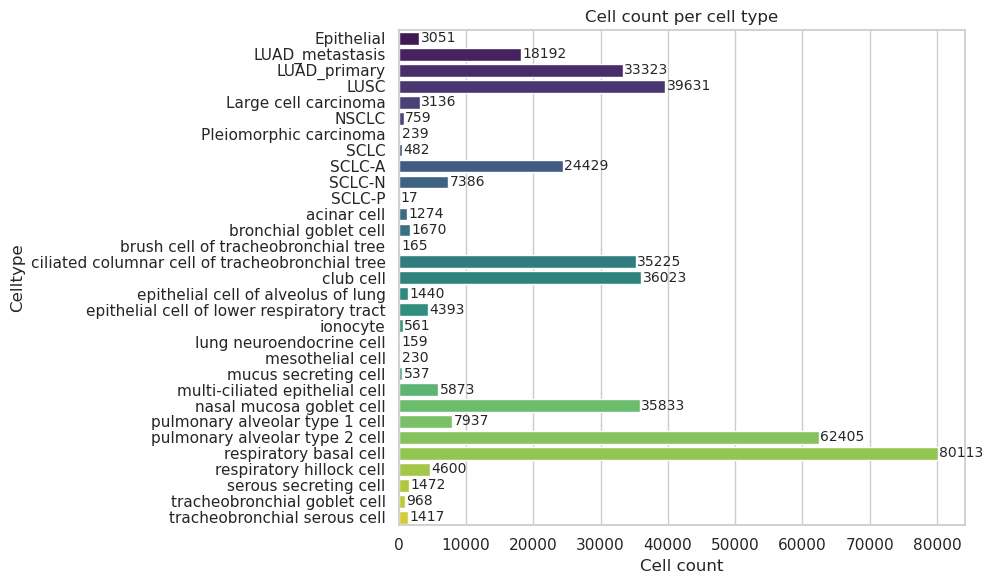

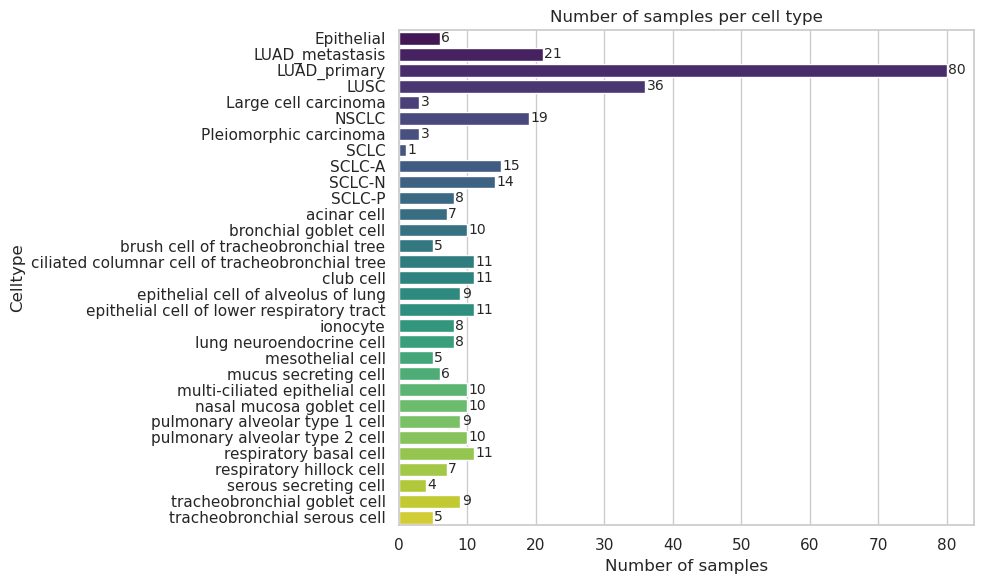

In [ ]:
sns.set(style="whitegrid")

# Plot: cell count per type
plt.figure(figsize=(10, 6))
ax = sns.barplot(y=cells_per_type.index, x=cells_per_type.values, palette="viridis")
plt.title("Cell count per cell type")
plt.xlabel("Cell count")

for index, value in enumerate(cells_per_type.values):
    ax.text(value + 200, index, str(value), va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Plot: sample count per type
plt.figure(figsize=(10, 6))
ax = sns.barplot(y=samples_per_type.index, x=samples_per_type.values, palette="viridis")
plt.title("Number of samples per cell type")
plt.xlabel("Number of samples")

for index, value in enumerate(samples_per_type.values):
    ax.text(value + 0.2, index, str(value), va='center', fontsize=10)

plt.tight_layout()
plt.show()

Before HVG/PC/PCA, filter out samples with <100 cells

Also exclude Pleiomorphic carcinoma due to very low cell count

In [ ]:
sample_counts = adata_merged.obs["Sample"].value_counts()

valid_samples = sample_counts[
    (sample_counts >= 100) | 
    (adata_merged.obs.groupby("Sample")["Celltype"].first() == "lung neuroendocrine cell")
].index

# Оставляем только valid_samples
adata_merged = adata_merged[adata_merged.obs["Sample"].isin(valid_samples)].copy()

In [ ]:
# Remove Pleiomorphic carcinoma and NSCLC
unwanted_types = ["Pleiomorphic carcinoma", "NSCLC"]
adata_merged = adata_merged[~adata_merged.obs["Celltype"].isin(unwanted_types)].copy()

In [47]:
print(adata_merged.obs["Sample"].value_counts())

Sample
Barbry_Leroy_2020        67208
Nawijn_2021              43397
Jain_Misharin_2021       42875
Banovich_Kropski_2020    37273
Seibold_2020             33552
                         ...  
GSM4453597_P22             142
GSM4453613_P38             140
LUNG_T31                   121
SSN28                      121
RU1065C                    100
Name: count, Length: 106, dtype: int64


In [ ]:
# Recalculate cancer stats

cancer_types = adata_merged.obs["Celltype"].unique()
samples_per_type = adata_merged.obs.groupby("Celltype")["Sample"].nunique()
cells_per_type = adata_merged.obs.groupby("Celltype").size()

print("Lung cancer types:", cancer_types)
print("\nSamples per type:")
print(samples_per_type)
print("\nCells per type:")
print(cells_per_type)

Типы рака легкого: ['LUAD_primary' 'LUAD_metastasis' 'Large cell carcinoma' 'SCLC'
 'Epithelial' 'pulmonary alveolar type 2 cell' 'respiratory basal cell'
 'pulmonary alveolar type 1 cell'
 'ciliated columnar cell of tracheobronchial tree'
 'respiratory hillock cell' 'nasal mucosa goblet cell' 'club cell'
 'tracheobronchial serous cell'
 'epithelial cell of lower respiratory tract'
 'multi-ciliated epithelial cell' 'bronchial goblet cell'
 'lung neuroendocrine cell' 'mucus secreting cell'
 'tracheobronchial goblet cell' 'epithelial cell of alveolus of lung'
 'acinar cell' 'mesothelial cell' 'serous secreting cell' 'ionocyte'
 'brush cell of tracheobronchial tree' 'SCLC-N' 'SCLC-A' 'SCLC-P' 'LUSC']

Количество сэмплов на каждый тип:
Celltype
Epithelial                                          5
LUAD_metastasis                                    15
LUAD_primary                                       42
LUSC                                               15
Large cell carcinoma             

##### Data filtering completed

In [ ]:
# Identification of Highly Variable Genes
sc.pp.highly_variable_genes(adata_merged, n_top_genes=7000, batch_key="Sample")
adata_lung_highly_variable = adata_merged[:, adata_merged.var.highly_variable]

# ПDimensionality Reduction
sc.tl.pca(adata_lung_highly_variable)

# Neighborhood Graph, UMAP, and Leiden Clustering
sc.pp.neighbors(adata_lung_highly_variable, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata_lung_highly_variable)
sc.tl.leiden(adata_lung_highly_variable)

... storing 'Celltype' as categorical


... storing 'dataset' as categorical
2025-04-24 19:58:07.763735: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 19:58:07.783406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745499487.806285 3134597 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745499487.812750 3134597 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 19:58:07.834433: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is

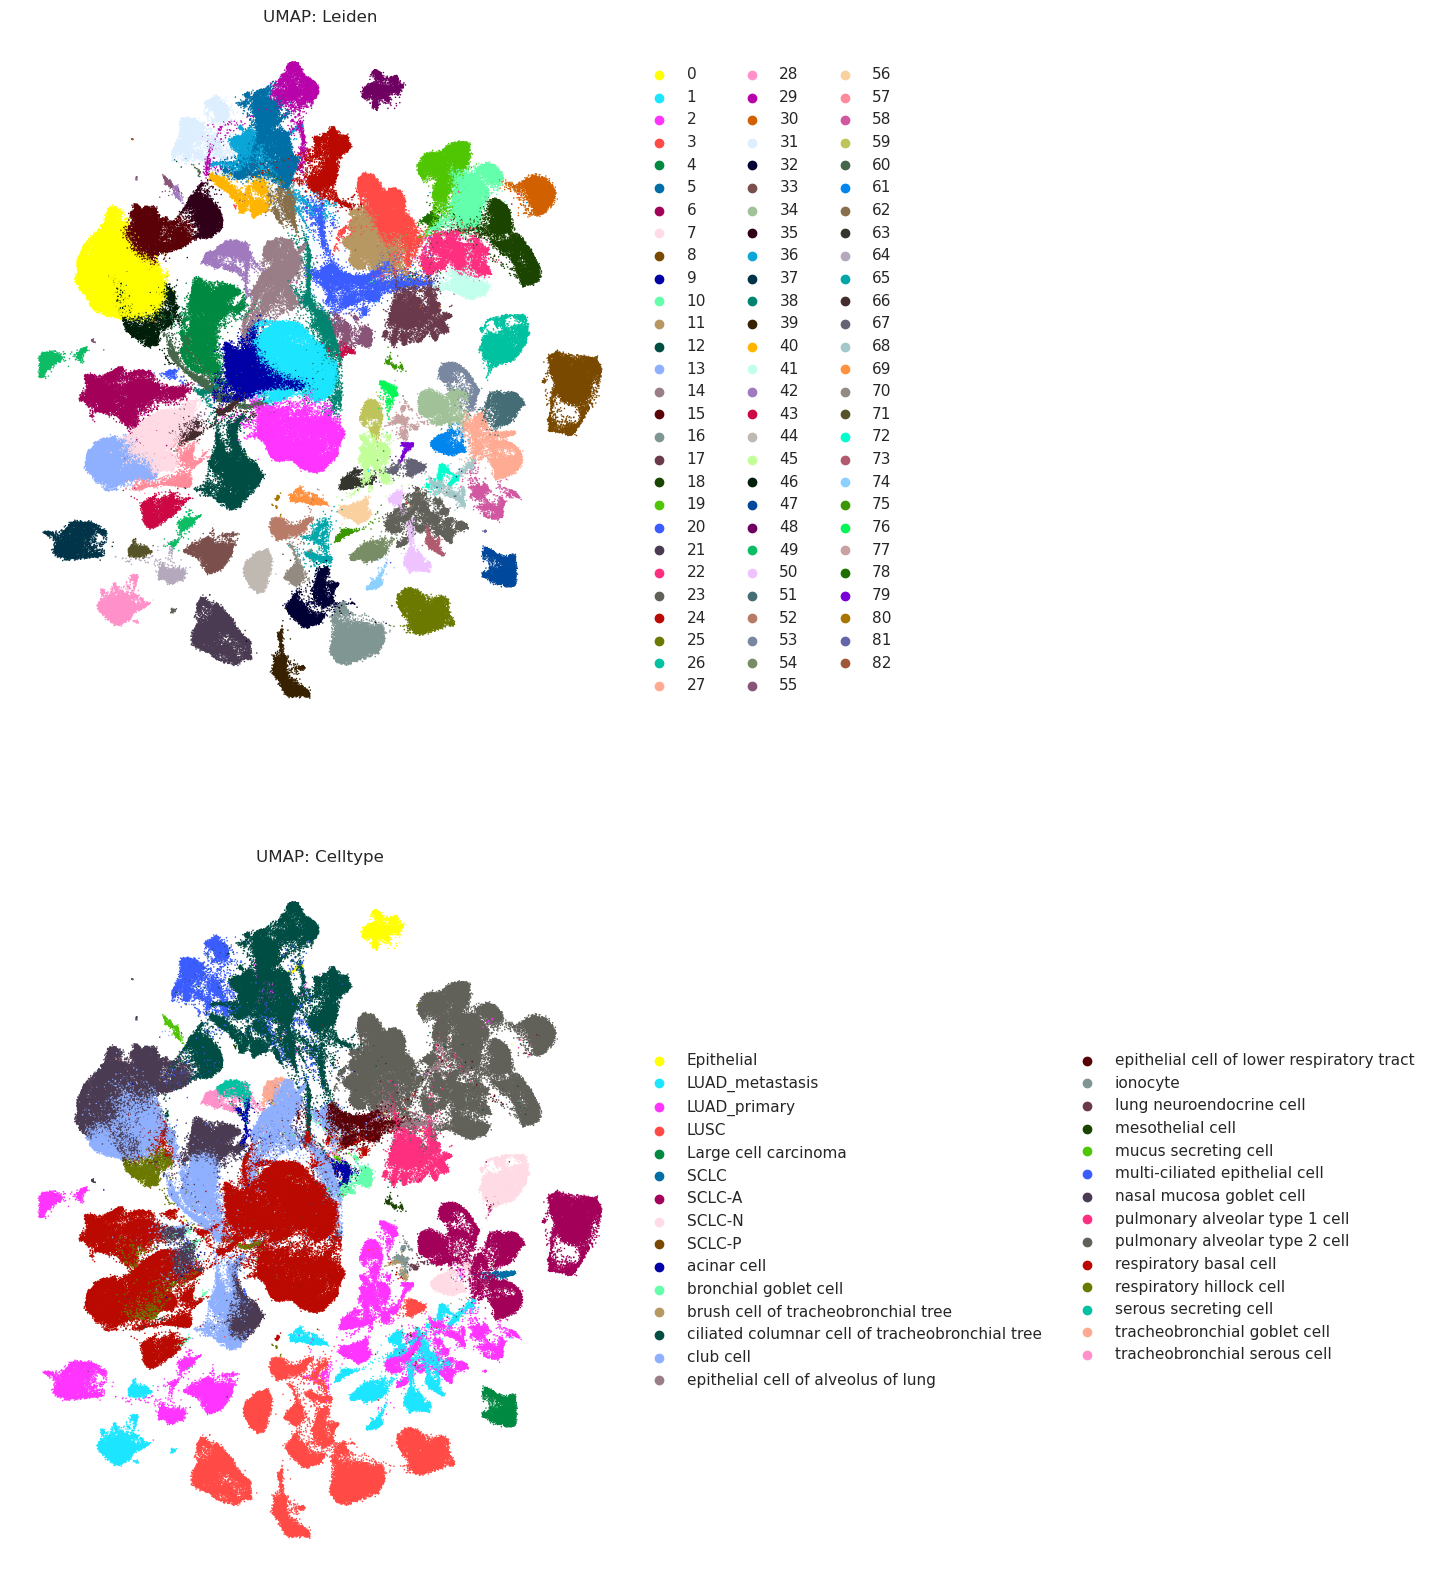

In [ ]:
# UMAP Visualization
fig, axes = plt.subplots(2, 1, figsize=(8, 20), gridspec_kw={'wspace': 1})

# Leiden
sc.pl.umap(adata_lung_highly_variable, color="leiden", frameon=False, ax=axes[0], show=False, size=5)
axes[0].set_title("UMAP: Leiden")

# Dataset
sc.pl.umap(adata_lung_highly_variable, color="Celltype", frameon=False, ax=axes[1], show=False, size=5)
axes[1].set_title("UMAP: Celltype")

plt.tight_layout()
plt.show()

In [ ]:
# Integration Using Harmony (Batch = Sample)
# Run Harmony on PCA results (adata_merged.obsm["X_pca"]), metadata (adata.obs), and batch_key (vars_use)

# Create a new object to store Harmony-integrated data
adata_harmony = adata_lung_highly_variable

harmony_outs = hm.run_harmony(adata_harmony.obsm["X_pca"],
                    adata_harmony.obs,
                     vars_use="Sample")

# Store Harmony-corrected PCA components in `adata_harmony.obsm`
adata_harmony.obsm["X_pca_harmony"] = harmony_outs.Z_corr.T
adata_harmony.obsm["X_pca"] = adata_harmony.obsm["X_pca_harmony"]

2025-04-24 20:10:42,396 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...


2025-04-24 20:12:58,711 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-04-24 20:13:00,650 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2025-04-24 20:17:03,805 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2025-04-24 20:21:05,181 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2025-04-24 20:25:07,588 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2025-04-24 20:29:10,620 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2025-04-24 20:33:16,567 - harmonypy - INFO - Converged after 5 iterations
Converged after 5 iterations


In [ ]:
# Recompute neighbors and apply UMAP and Leiden clustering based on Harmony PCA
sc.pp.neighbors(adata_harmony, use_rep='X_pca_harmony')
sc.tl.umap(adata_harmony)
sc.tl.leiden(adata_harmony, resolution=0.5)

In [53]:
adata_harmony.write('Lung_integrated_data.h5ad')

In [3]:
adata_harmony = sc.read_h5ad("Lung_integrated_data.h5ad")

In [ ]:
### Cell Type Annotation for `lung_hca_vieira` Dataset
predictions_lung = celltypist.annotate(
  adata_harmony[adata_harmony.obs['dataset'] == 'lung_hca_vieira'],
  over_clustering='leiden',
  model='/home/patskanivan/.celltypist/data/models/Human_Lung_Atlas.pkl',
  majority_voting=True
)

# Redo cell type prediction specifically for `lung_hca_vieira`
lung_cells_mask = adata_harmony.obs['dataset'] == 'lung_hca_vieira'
predictions = predictions_lung.predicted_labels['majority_voting'].astype(str)

# Sanity check: compare the number of lung cells and prediction outputs
print(f"Number of lung cells: {sum(lung_cells_mask)}")
print(f"Number of predictions: {len(predictions)}")

# Apply predictions to the correct subset of lung cells
adata_harmony.obs.loc[lung_cells_mask, 'Celltype'] = predictions.values

⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 3022 cells and 7000 genes
🔗 Matching reference genes in the model
🧬 2212 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


Количество lung клеток: 3022
Количество предсказаний: 3022


In [ ]:
# Standardize synonymous cell type labels
rename_dict = {
    "pulmonary alveolar type 2 cell": "AT2",
    "pulmonary alveolar type 1 cell" : "AT1",
    "AT2 proliferating" : "AT2"
}

In [10]:
adata_harmony.obs["Celltype"] = adata_harmony.obs["Celltype"].replace(rename_dict)

In [11]:
adata_harmony.obs["Celltype"].unique()

array(['LUAD_primary', 'LUAD_metastasis', 'Large cell carcinoma', 'SCLC',
       'Multiciliated (non-nasal)', 'AT2', 'pre-TB secretory',
       'Suprabasal', 'AT1', 'respiratory basal cell',
       'ciliated columnar cell of tracheobronchial tree',
       'respiratory hillock cell', 'nasal mucosa goblet cell',
       'club cell', 'tracheobronchial serous cell',
       'epithelial cell of lower respiratory tract',
       'multi-ciliated epithelial cell', 'bronchial goblet cell',
       'lung neuroendocrine cell', 'mucus secreting cell',
       'tracheobronchial goblet cell',
       'epithelial cell of alveolus of lung', 'acinar cell',
       'mesothelial cell', 'serous secreting cell', 'ionocyte',
       'brush cell of tracheobronchial tree', 'SCLC-N', 'SCLC-A',
       'SCLC-P', 'LUSC'], dtype=object)

In [12]:
print(adata_harmony.obs["Celltype"].value_counts())

Celltype
respiratory basal cell                             80113
AT2                                                65214
LUSC                                               38986
club cell                                          36023
nasal mucosa goblet cell                           35833
ciliated columnar cell of tracheobronchial tree    35225
LUAD_primary                                       32247
SCLC-A                                             24340
LUAD_metastasis                                    17963
AT1                                                 7983
SCLC-N                                              7383
multi-ciliated epithelial cell                      5873
respiratory hillock cell                            4600
epithelial cell of lower respiratory tract          4393
Large cell carcinoma                                3136
bronchial goblet cell                               1670
serous secreting cell                               1472
epithelial cell of alv

In [ ]:
### Filter Rare Cell Types Based on Abundance
# Count the number of cells in each annotated cell type
celltype_counts = adata_harmony.obs["Celltype"].value_counts()

# Identify cell types that contain 100 or more cells
valid_samples = celltype_counts[celltype_counts >= 100].index

# Retain only cells of cell types with sufficient representation (≥100 cells)
adata_harmony = adata_harmony[adata_harmony.obs["Celltype"].isin(valid_samples)].copy()

In [14]:
print(adata_harmony.obs["Celltype"].value_counts())

Celltype
respiratory basal cell                             80113
AT2                                                65214
LUSC                                               38986
club cell                                          36023
nasal mucosa goblet cell                           35833
ciliated columnar cell of tracheobronchial tree    35225
LUAD_primary                                       32247
SCLC-A                                             24340
LUAD_metastasis                                    17963
AT1                                                 7983
SCLC-N                                              7383
multi-ciliated epithelial cell                      5873
respiratory hillock cell                            4600
epithelial cell of lower respiratory tract          4393
Large cell carcinoma                                3136
bronchial goblet cell                               1670
serous secreting cell                               1472
epithelial cell of alv

In [ ]:
### Retrieve Lung Cancer Statistics
# Get statistics by cancer type
# 1. What lung cancer types are present in the dataset?
cancer_types = adata_harmony.obs["Celltype"].unique()

# 2. How many samples are there per type?
samples_per_type = adata_harmony.obs.groupby("Celltype")["Sample"].nunique()

# 3. How many cells are there per type?
cells_per_type = adata_harmony.obs.groupby("Celltype").size()

# Display the results
print("Lung cancer types:", cancer_types)
print("\nNumber of samples per type:")
print(samples_per_type)
print("\nNumber of cells per type:")
print(cells_per_type)

Типы рака легкого: ['LUAD_primary' 'LUAD_metastasis' 'Large cell carcinoma' 'SCLC'
 'Multiciliated (non-nasal)' 'AT2' 'AT1' 'respiratory basal cell'
 'ciliated columnar cell of tracheobronchial tree'
 'respiratory hillock cell' 'nasal mucosa goblet cell' 'club cell'
 'tracheobronchial serous cell'
 'epithelial cell of lower respiratory tract'
 'multi-ciliated epithelial cell' 'bronchial goblet cell'
 'lung neuroendocrine cell' 'mucus secreting cell'
 'tracheobronchial goblet cell' 'epithelial cell of alveolus of lung'
 'acinar cell' 'mesothelial cell' 'serous secreting cell' 'ionocyte'
 'brush cell of tracheobronchial tree' 'SCLC-N' 'SCLC-A' 'LUSC']

Количество сэмплов на каждый тип:
Celltype
AT1                                                14
AT2                                                15
LUAD_metastasis                                    15
LUAD_primary                                       42
LUSC                                               15
Large cell carcinoma        

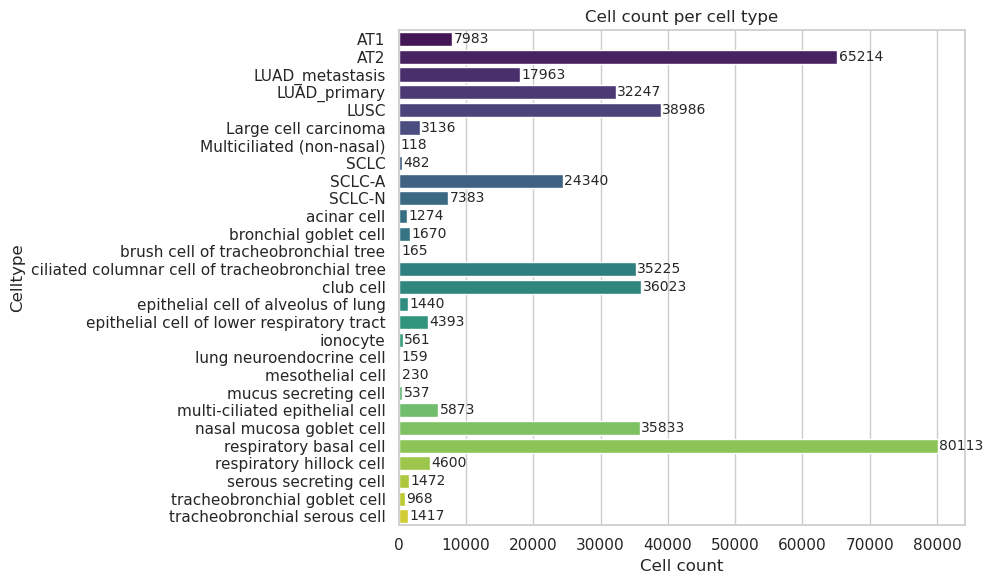

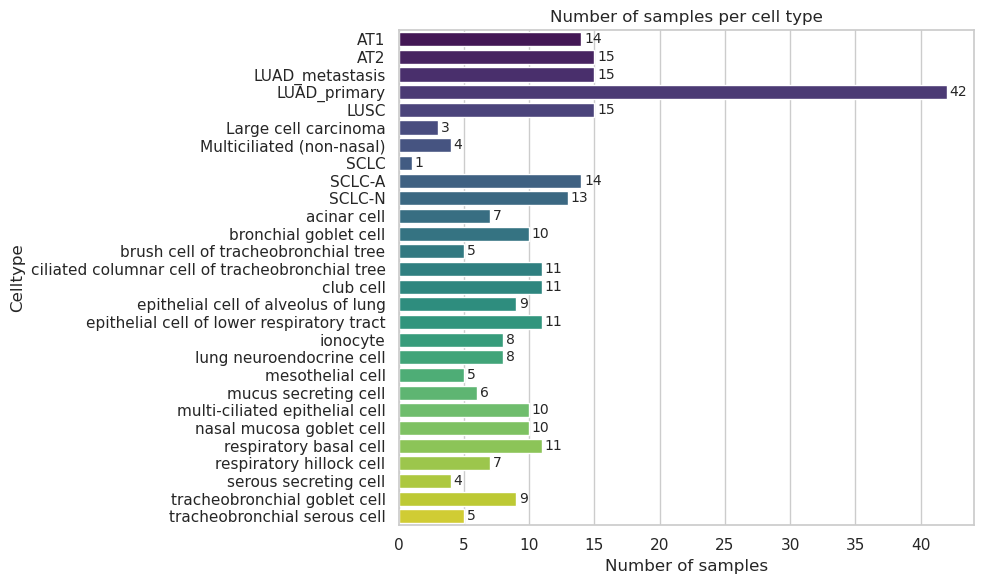

In [ ]:
# Set plot style
sns.set(style="whitegrid")

# 1. Visualize cell count per cancer type (horizontal bars)
plt.figure(figsize=(10, 6))
ax = sns.barplot(y=cells_per_type.index, x=cells_per_type.values, palette="viridis")
plt.title("Cell count per cell type")
plt.xlabel("Cell count")

# Add annotations showing the number of cells on each bar
for index, value in enumerate(cells_per_type.values):
    ax.text(value + 200, index, str(value), va='center', fontsize=10)

plt.tight_layout()
plt.show()

# 2. Visualize number of samples per cancer type (horizontal bars)
plt.figure(figsize=(10, 6))
ax = sns.barplot(y=samples_per_type.index, x=samples_per_type.values, palette="viridis")
plt.title("Number of samples per cell type")
plt.xlabel("Number of samples")

# Add annotations showing the number of samples on each bar
for index, value in enumerate(samples_per_type.values):
    ax.text(value + 0.2, index, str(value), va='center', fontsize=10)

plt.tight_layout()
plt.show()


... storing 'Celltype' as categorical


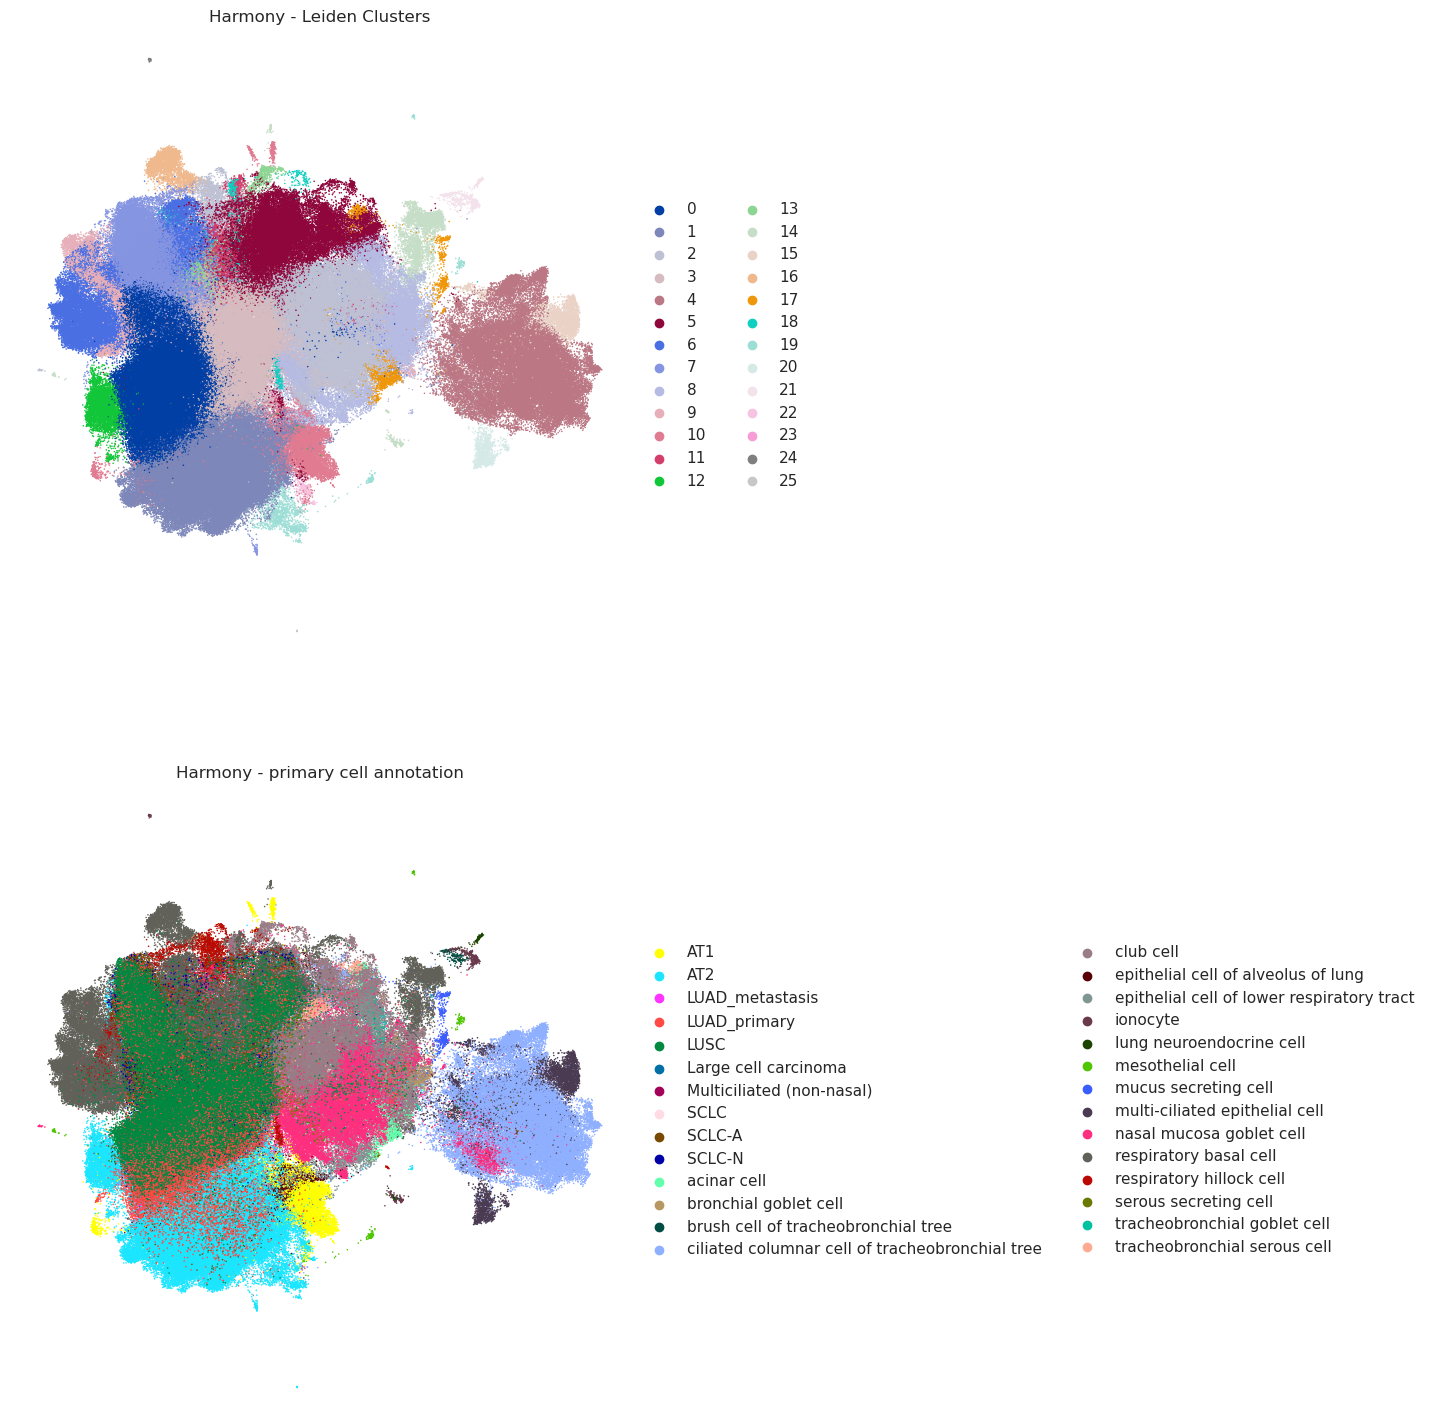

In [ ]:
### Create UMAP Subplots
# Create UMAP plots for Leiden clusters and cell types
fig, axes = plt.subplots(2, 1, figsize=(8, 18), gridspec_kw={'wspace': 1})

# Leiden clusters
sc.pl.umap(adata_harmony, color="leiden", frameon=False, ax=axes[0], show=False, s=5)
axes[0].set_title("Harmony - Leiden Clusters")

# Celltype annotations
sc.pl.umap(adata_harmony, color="Celltype", frameon=False, ax=axes[1], show=False, size=5)
axes[1].set_title("Harmony - primary cell annotation")

# Final layout adjustment
plt.tight_layout()
plt.show()


### Generate Pseudobulk Samples by (Sample + Celltype)

In [ ]:
# Select neuroendocrine cells
neuro_mask = adata_harmony.obs["Celltype"] == "lung neuroendocrine cell"
adata_neuro = adata_harmony[neuro_mask].copy()

In [ ]:
adata_pseudo = adata_harmony.copy()

# If duplicate cell names exist — make them unique
if adata_pseudo.obs_names.has_duplicates:
    adata_pseudo.obs_names_make_unique()

pbs = []

# Reverse log1p transformation of counts
if sp.issparse(adata_pseudo.X):
    adata_pseudo.X.data = np.expm1(adata_pseudo.X.data)  # Only non-zero elements
else:
    adata_pseudo.X = np.expm1(adata_pseudo.X)

# Generate pseudobulk by (sample, cell type)
for (sample, cell_type), samp_cell_subset in adata_pseudo.obs.groupby(["Sample", "Celltype"]):
    sample_cell_sum = samp_cell_subset.shape[0]

    if sample_cell_sum > 100:  # Filter by minimum number of cells in group
        # Select relevant cells
        subset_adata = adata_pseudo[samp_cell_subset.index]

        # Sum expression values
        rep_data = sc.AnnData(X=subset_adata.X.sum(axis=0),
                              var=subset_adata.var)  # Preserve gene annotations

        # Metadata
        rep_data.obs_names = [f"{sample}_{cell_type}"]  # Name = Sample_CellType
        rep_data.obs["Sample"] = sample
        rep_data.obs["Celltype"] = cell_type
        rep_data.obs["dataset"] = subset_adata.obs["dataset"].iloc[0]
        rep_data.obs["cnv_status"] = subset_adata.obs["cnv_status"].iloc[0]

        pbs.append(rep_data)

# Combine pseudobulk samples
adata_pseudobulk = sc.concat(pbs)

Создаем уникальные имена клеток...


In [29]:
adata_pseudobulk.obs

Sample  \
BRONCHO_11_LUAD_metastasis                                         BRONCHO_11   
BRONCHO_58_LUAD_primary                                            BRONCHO_58   
Banovich_Kropski_2020_AT1                               Banovich_Kropski_2020   
Banovich_Kropski_2020_AT2                               Banovich_Kropski_2020   
Banovich_Kropski_2020_ciliated columnar cell of...      Banovich_Kropski_2020   
...                                                                       ...   
pan_blueprint_lung_BT1296_LUAD_primary              pan_blueprint_lung_BT1296   
pan_blueprint_lung_BT1297_LUAD_primary              pan_blueprint_lung_BT1297   
pan_blueprint_lung_BT1298_Large cell carcinoma      pan_blueprint_lung_BT1298   
pan_blueprint_lung_BT1299_Large cell carcinoma      pan_blueprint_lung_BT1299   
pan_blueprint_lung_BT1300_Large cell carcinoma      pan_blueprint_lung_BT1300   

                                                                                           Celltype  \
BRONCHO_11_LUAD_metastasis                                                          LUAD_metastasis   
BRONCHO_58_LUAD_primary                                                                LUAD_primary   
Banovich_Kropski_2020_AT1                                                                       AT1   
Banovich_Kropski_2020_AT2                                                                       AT2   
Banovich_Kropski_2020_ciliated columnar cell of...  ciliated columnar cell of tracheobronchial tree   
...                                                                                             ...   
pan_blueprint_lung_BT1296_LUAD_primary                                                 LUAD_primary   
pan_blueprint_lung_BT1297_LUAD_primary                                                 LUAD_primary   
pan_blueprint_lung_BT1298_Large cell carcinoma                                 Large cell carcinoma   
pan_blueprint_lung_BT1299_Large cell carcinoma                                 Large cell carcinoma   
pan_blueprint_lung_BT1300_Large cell carcinoma                                 Large cell carcinoma   

                                                                        dataset  \
BRONCHO_11_LUAD_metastasis                                     lu_adc_GSE131907   
BRONCHO_58_LUAD_primary                                        lu_adc_GSE131907   
Banovich_Kropski_2020_AT1                                       Lung_normal_new   
Banovich_Kropski_2020_AT2                                       Lung_normal_new   
Banovich_Kropski_2020_ciliated columnar cell of...              Lung_normal_new   
...                                                                         ...   
pan_blueprint_lung_BT1296_LUAD_primary              lu_nsclc_pan_blueprint_lung   
pan_blueprint_lung_BT1297_LUAD_primary              lu_nsclc_pan_blueprint_lung   
pan_blueprint_lung_BT1298_Large cell carcinoma      lu_nsclc_pan_blueprint_lung   
pan_blueprint_lung_BT1299_Large cell carcinoma      lu_nsclc_pan_blueprint_lung   
pan_blueprint_lung_BT1300_Large cell carcinoma      lu_nsclc_pan_blueprint_lung   

                                                   cnv_status  
BRONCHO_11_LUAD_metastasis                              tumor  
BRONCHO_58_LUAD_primary                                 tumor  
Banovich_Kropski_2020_AT1                              normal  
Banovich_Kropski_2020_AT2                              normal  
Banovich_Kropski_2020_ciliated columnar cell of...     normal  
...                                                       ...  
pan_blueprint_lung_BT1296_LUAD_primary                  tumor  
pan_blueprint_lung_BT1297_LUAD_primary                  tumor  
pan_blueprint_lung_BT1298_Large cell carcinoma          tumor  
pan_blueprint_lung_BT1299_Large cell carcinoma          tumor  
pan_blueprint_lung_BT1300_Large cell carcinoma          tumor  

[166 rows x 4 columns]

In [ ]:
# Create a copy of the data
adata_pseudo_neuro = adata_neuro.copy()

pbs = []

# Reverse log1p transformation of counts
if sp.issparse(adata_pseudo_neuro.X):
    adata_pseudo_neuro.X.data = np.expm1(adata_pseudo_neuro.X.data)  # For sparse matrices
else:
    adata_pseudo_neuro.X = np.expm1(adata_pseudo_neuro.X)  # For dense matrices

# Generate pseudobulk per cell type (neuroendocrine)
for cell_type, cell_subset in adata_pseudo_neuro.obs.groupby("Celltype"):
    n_cells = cell_subset.shape[0]

    # Select relevant cells
    subset_adata = adata_pseudo_neuro[cell_subset.index]

    # Sum expression (check for sparsity)
    if sp.issparse(subset_adata.X):
        sum_expr = subset_adata.X.sum(axis=0).A1  # Convert to dense array
    else:
        sum_expr = subset_adata.X.sum(axis=0)

    # Create AnnData object for pseudobulk sample
    rep_data = sc.AnnData(
        X=sum_expr[np.newaxis, :],  # Add batch axis
        var=subset_adata.var.copy()
    )

    # Metadata
    rep_data.obs_names = [f"{cell_type}_pseudobulk"]
    rep_data.obs["Celltype"] = cell_type
    rep_data.obs["n_cells"] = n_cells
    rep_data.obs["dataset"] = subset_adata.obs["dataset"].iloc[0]
    rep_data.obs["cnv_status"] = subset_adata.obs["cnv_status"].iloc[0]

    pbs.append(rep_data)

# Combine pseudobulk samples
adata_neuro_pseudobulk = sc.concat(pbs)

In [23]:
adata_neuro_pseudobulk.obs

Celltype  n_cells  \
lung neuroendocrine cell_pseudobulk  lung neuroendocrine cell      159   

                                             dataset cnv_status  
lung neuroendocrine cell_pseudobulk  Lung_normal_new     normal

In [ ]:
# Merge all pseudobulk samples
adata_pseudobulk = sc.concat([adata_pseudobulk, adata_neuro_pseudobulk])

In [31]:
print(adata_pseudobulk.obs["Celltype"].value_counts())

Celltype
LUAD_primary                                       42
LUAD_metastasis                                    15
LUSC                                               15
AT2                                                12
ciliated columnar cell of tracheobronchial tree    11
SCLC-A                                             10
respiratory basal cell                              7
club cell                                           6
epithelial cell of lower respiratory tract          5
AT1                                                 5
multi-ciliated epithelial cell                      5
acinar cell                                         4
nasal mucosa goblet cell                            4
epithelial cell of alveolus of lung                 3
Large cell carcinoma                                3
SCLC-N                                              3
respiratory hillock cell                            3
ionocyte                                            3
bronchial goblet ce

In [ ]:
adata_pseudobulk.write('Lung_pseudobulk_data.h5ad')

In [3]:
adata_pseudobulk = sc.read_h5ad('Lung_pseudobulk_data.h5ad')

In [ ]:
### PCA and UMAP
sc.pp.normalize_total(adata_pseudobulk, target_sum=1e4)  # Normalization
sc.pp.log1p(adata_pseudobulk)  # Log transformation
sc.pp.pca(adata_pseudobulk, n_comps=20)  # PCA
sc.pp.neighbors(adata_pseudobulk)  # Neighborhood graph
sc.tl.umap(adata_pseudobulk)  # UMAP

In [34]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:
#!pip install distinctipy

In [ ]:
### Generate color palette for plots
import distinctipy

# Generate 40 maximally distinct colors
palette_40 = distinctipy.get_colors(40)

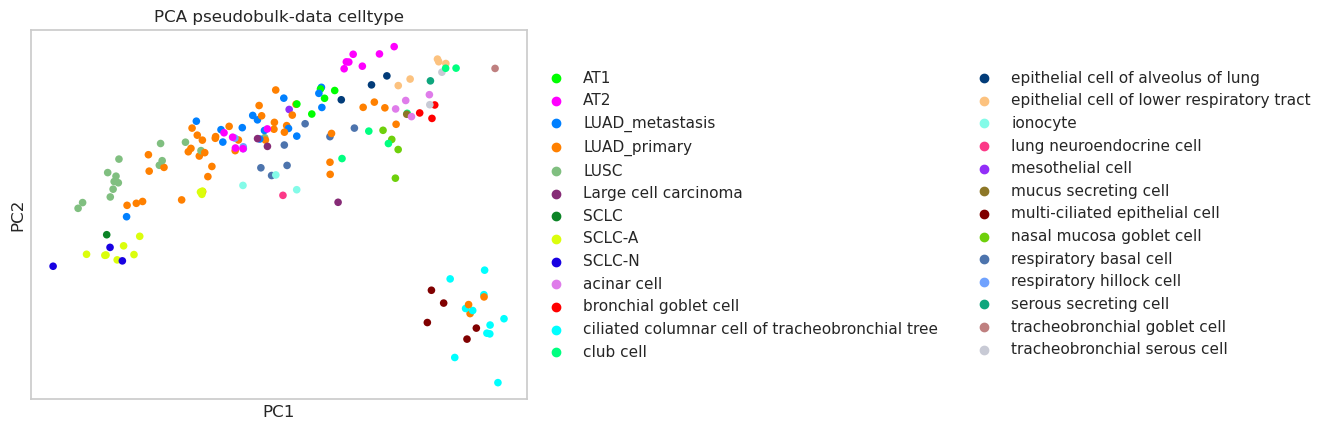

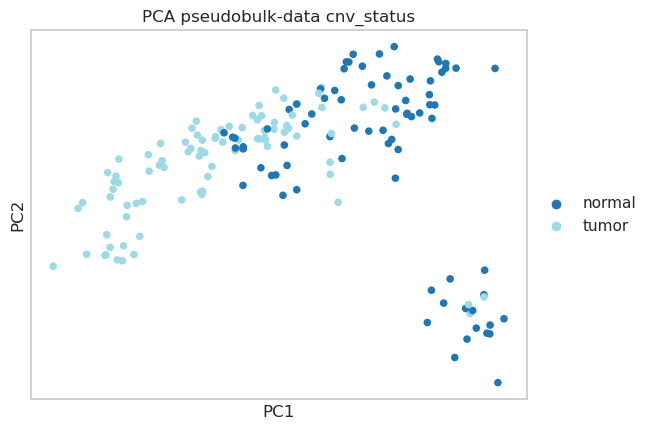

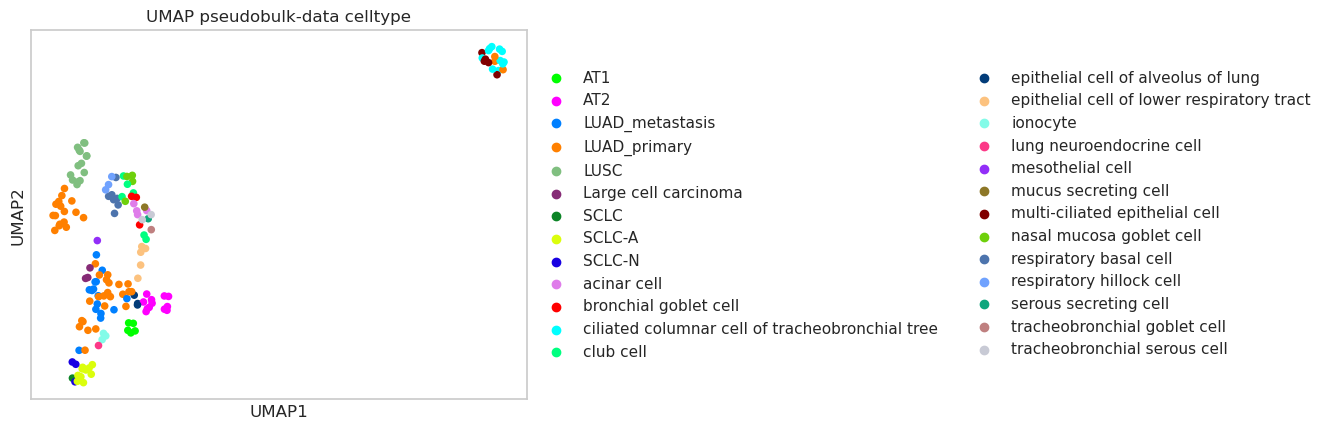

In [ ]:
# PCA and UMAP visualization
sc.pl.pca_scatter(
    adata_pseudobulk, 
    title="PCA pseudobulk-data celltype", 
    color="Celltype", 
    size=120, 
    palette=palette_40
)

sc.pl.pca_scatter(
    adata_pseudobulk, 
    title="PCA pseudobulk-data cnv_status", 
    color="cnv_status", 
    size=120, 
    palette="tab20"
)

sc.pl.umap(
    adata_pseudobulk, 
    title="UMAP pseudobulk-data celltype", 
    color="Celltype", 
    size=120,
    palette=palette_40
)

PCoA on all genes in pseudobulk samples


To perform PCoA, first compute a Bray-Curtis distance matrix, then apply MDS.

In [ ]:
from scipy.spatial.distance import cdist
from sklearn.manifold import MDS
import matplotlib.pyplot as plt


# Bray-Curtis distance matrix
distance_matrix = cdist(adata_pseudobulk.X, adata_pseudobulk.X, metric='braycurtis')

# Perform PCoA using MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pcoa_coordinates = mds.fit_transform(distance_matrix)

# Store PCoA coordinates in the AnnData object
adata_pseudobulk.obsm['X_pcoa'] = pcoa_coordinates

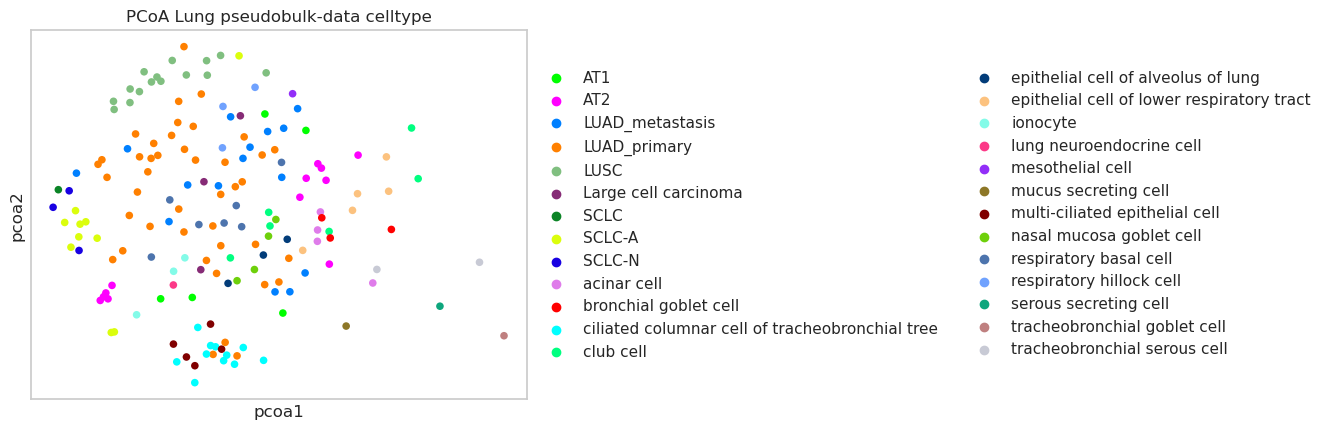

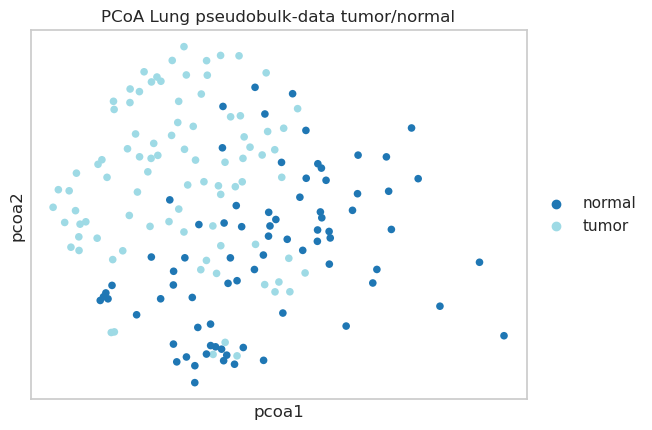

In [38]:
sc.pl.embedding(
    adata_pseudobulk,
    basis="pcoa",
    title="PCoA Lung pseudobulk-data celltype", 
    color="Celltype", 
    size=120, 
    palette=palette_30
)

sc.pl.embedding(
    adata_pseudobulk,
    basis="pcoa",
    title="PCoA Lung pseudobulk-data tumor/normal", 
    color="cnv_status", 
    size=120, 
    palette="tab20"
)

### Top-100 marker gene identification using Scanpy


In [ ]:
# Dictionary to store marker genes
marker_genes = {}

In [40]:
adata_pseudobulk.obs['Celltype'].unique()

['LUAD_metastasis', 'LUAD_primary', 'AT1', 'AT2', 'ciliated columnar cell of tracheobronchial tree', ..., 'bronchial goblet cell', 'SCLC-A', 'SCLC-N', 'Large cell carcinoma', 'lung neuroendocrine cell']
Length: 26
Categories (26, object): ['AT1', 'AT2', 'LUAD_metastasis', 'LUAD_primary', ..., 'respiratory hillock cell', 'serous secreting cell', 'tracheobronchial goblet cell', 'tracheobronchial serous cell']

In [ ]:
# Display number of samples per cell type
celltype_counts = adata_pseudobulk.obs['Celltype'].value_counts()
print(celltype_counts)

Celltype
LUAD_primary                                       42
LUAD_metastasis                                    15
LUSC                                               15
AT2                                                12
ciliated columnar cell of tracheobronchial tree    11
SCLC-A                                             10
respiratory basal cell                              7
club cell                                           6
epithelial cell of lower respiratory tract          5
AT1                                                 5
multi-ciliated epithelial cell                      5
nasal mucosa goblet cell                            4
acinar cell                                         4
Large cell carcinoma                                3
ionocyte                                            3
SCLC-N                                              3
epithelial cell of alveolus of lung                 3
bronchial goblet cell                               3
respiratory hillock

In [ ]:
# List of cell types with only one sample
single_sample_celltypes = celltype_counts[celltype_counts == 1].index.tolist()

# Filter out cell types with only one sample
adata_pseudobulk_filtered = adata_pseudobulk[~adata_pseudobulk.obs['Celltype'].isin(single_sample_celltypes)].copy()

In [9]:
adata_pseudobulk_filtered.write("lung_pseudobulk_filtered.h5ad")

In [ ]:
# We need only normal tissue for DEG caclculating, create pseudobulc without cancer samples
exclude_values = ['LUAD_metastasis', 'LUSC', 'LUAD_primary', 'Large cell carcinoma', 'SCLC', 'SCLC-A', 'SCLC-N']
pseudobulk_no_cancer = adata_pseudobulk_filtered[~adata_pseudobulk_filtered.obs['Celltype'].isin(exclude_values)].copy()

pseudobulk_no_cancer.obs['Celltype'].unique()

['AT1', 'AT2', 'ciliated columnar cell of tracheobronchial tree', 'club cell', 'epithelial cell of alveolus of lung', ..., 'ionocyte', 'nasal mucosa goblet cell', 'respiratory hillock cell', 'tracheobronchial serous cell', 'bronchial goblet cell']
Length: 14
Categories (14, object): ['AT1', 'AT2', 'acinar cell', 'bronchial goblet cell', ..., 'nasal mucosa goblet cell', 'respiratory basal cell', 'respiratory hillock cell', 'tracheobronchial serous cell']

In [7]:
pseudobulk_no_cancer.write("lung_pseudobulk_no_cancer.h5ad")

In [8]:
pseudobulk_no_cancer

AnnData object with n_obs × n_vars = 73 × 7000
    obs: 'Celltype', 'dataset', 'cnv_status'

In [44]:
sc.tl.rank_genes_groups(pseudobulk_no_cancer, groupby='Celltype', method='wilcoxon', n_genes=100)

In [ ]:
# Extract top marker genes for each cell type
all_markers = []
for ct in pseudobulk_no_cancer.obs['Celltype'].unique():
    markers = sc.get.rank_genes_groups_df(pseudobulk_no_cancer, group=ct).head(100)['names'].tolist()
    all_markers.extend(markers)

### The expression matrix for the top-100 genes for each normal tissue type will be built using DEG results via Wilcoxon test. At this stage, we exclude tumor samples, as we only compare normal tissues.

Create a DataFrame of top-10 genes for normal lung tissue types for ssGSEA gene-list

In [ ]:
# Calculate marker genes (top-10)
sc.tl.rank_genes_groups(pseudobulk_no_cancer, groupby='Celltype', method='wilcoxon', n_genes=10)

# Collect all results in one DataFrame
all_markers = []
for ct in pseudobulk_no_cancer.obs['Celltype'].unique():
    # Get DataFrame with genes, p-value, logFC, etc.
    markers_df = sc.get.rank_genes_groups_df(pseudobulk_no_cancer, group=ct)
    markers_df['Celltype'] = ct 
    all_markers.append(markers_df)

markers_stats_df = pd.concat(all_markers)
markers_stats_df.head()

names    scores  logfoldchanges     pvals  pvals_adj Celltype
0  PDLIM2  3.712652        3.264187  0.000205    0.01166      AT1
1    TNS1  3.712652        3.057340  0.000205    0.01166      AT1
2    CFL2  3.712652        2.648543  0.000205    0.01166      AT1
3   FADS3  3.712652        4.696511  0.000205    0.01166      AT1
4    CTIF  3.712652        2.731348  0.000205    0.01166      AT1

In [ ]:
# Top-100 genes
sc.tl.rank_genes_groups(pseudobulk_no_cancer, groupby='Celltype', method='wilcoxon', n_genes=100)
marker_genes = {
    'top10': set(),
    'top50': set(),
    'top100': set()
}

for ct in pseudobulk_no_cancer.obs['Celltype'].unique():
    genes_df = sc.get.rank_genes_groups_df(pseudobulk_no_cancer, group=ct)
    marker_genes['top10'].update(genes_df['names'].head(10))
    marker_genes['top50'].update(genes_df['names'].head(50))
    marker_genes['top100'].update(genes_df['names'].head(100))

top10_mask = pseudobulk_no_cancer.var_names.isin(marker_genes['top10'])
top50_mask = pseudobulk_no_cancer.var_names.isin(marker_genes['top50'])
top100_mask = pseudobulk_no_cancer.var_names.isin(marker_genes['top100'])

In [48]:
datasets_top10 = pd.DataFrame(
    pseudobulk_no_cancer.X[:, top10_mask].T,
    index=pseudobulk_no_cancer.var_names[top10_mask],
    columns=pseudobulk_no_cancer.obs_names
)
datasets_top10.to_csv("pseudobulk_top10_genes.csv")

In [49]:
datasets_top50 = pd.DataFrame(
    pseudobulk_no_cancer.X[:, top50_mask].T,
    index=pseudobulk_no_cancer.var_names[top50_mask],
    columns=pseudobulk_no_cancer.obs_names
)
datasets_top50.to_csv("pseudobulk_top50_genes.csv")

In [50]:
datasets_top100 = pd.DataFrame(
    pseudobulk_no_cancer.X[:, top100_mask].T,
    index=pseudobulk_no_cancer.var_names[top100_mask],
    columns=pseudobulk_no_cancer.obs_names
)
datasets_top100.to_csv("pseudobulk_top100_genes.csv")

In [ ]:
print("Top-10 genes:", datasets_top10.shape)  # (10 × number of samples)
print("Top-50 genes:", datasets_top50.shape)  # (50 × number of samples)
print("Top-100 genes:", datasets_top100.shape)  # (100 × number of samples)

Топ-10 генов: (136, 73)
Топ-50 генов: (613, 73)
Топ-100 генов: (1154, 73)


In [ ]:
### Calculate DEGs for each cell type group

# For names like "Dataset1_B_cell" -> keep only "B_cell"
pseudobulk_no_cancer.obs['PureCelltype'] = pseudobulk_no_cancer.obs['Celltype'].str.split('_').str[-2:].str.join('_')

# Check result:
print(pseudobulk_no_cancer.obs['PureCelltype'].unique())

# Calculate differential genes for each group of cells
sc.tl.rank_genes_groups(pseudobulk_no_cancer, groupby='PureCelltype', method='wilcoxon', n_genes=100)

# Extract results table
ranked_genes = pd.DataFrame({
    group: pseudobulk_no_cancer.uns['rank_genes_groups']['names'][group]
    for group in pseudobulk_no_cancer.uns['rank_genes_groups']['names'].dtype.names
})

# Collect unique top-N genes
def get_top_n_genes(n):
    top_genes = set()
    for col in ranked_genes.columns:
        top_genes.update(ranked_genes[col][:n])
    return list(top_genes)

# Create DataFrame for top genes
def create_datasets_df(top_genes):
    adata = pseudobulk_no_cancer  # replace with actual object if needed
    mask = np.isin(adata.var_names, top_genes)
    datasets_df = pd.DataFrame(
        adata.X[:, mask].T,
        index=adata.var_names[mask],
        columns=adata.obs_names
    )
    return datasets_df

# Save for top-10, top-50, top-100 genes
for n in [10, 50, 100]:
    genes = get_top_n_genes(n)
    df = create_datasets_df(genes)
    df.to_csv(f"lung_datasets_top{n}_genes.csv")

... storing 'PureCelltype' as categorical


['AT1' 'AT2' 'ciliated columnar cell of tracheobronchial tree' 'club cell'
 'epithelial cell of alveolus of lung'
 'epithelial cell of lower respiratory tract'
 'multi-ciliated epithelial cell' 'respiratory basal cell' 'acinar cell'
 'ionocyte' 'nasal mucosa goblet cell' 'respiratory hillock cell'
 'tracheobronchial serous cell' 'bronchial goblet cell']


In [ ]:
# Calculate differential genes for each cell type
top_n = 100
sc.tl.rank_genes_groups(adata_pseudobulk_filtered, groupby='Celltype', method='wilcoxon', n_genes=top_n)

# Extract result table
ranked_genes = pd.DataFrame({
    group: adata_pseudobulk_filtered.uns['rank_genes_groups']['names'][group]
    for group in adata_pseudobulk_filtered.uns['rank_genes_groups']['names'].dtype.names
})

# Collect top-N unique genes
def get_top_n_genes(n):
    top_genes = set()
    for col in ranked_genes.columns:
        top_genes.update(ranked_genes[col][:n])
    return list(top_genes)

# Create DataFrame from top genes
def create_datasets_df(top_genes):
    adata = adata_pseudobulk_filtered  # replace with actual object
    mask = np.isin(adata.var_names, top_genes)
    datasets_df = pd.DataFrame(
        adata.X[:, mask].T,
        index=adata.var_names[mask],
        columns=adata.obs_names
    )
    return datasets_df

# Save top-N gene expression matrices
for n in [10, 50, 100]:
    genes = get_top_n_genes(n)
    df = create_datasets_df(genes)
    df.to_csv(f"lung_datasets_top{n}_genes.csv")

In [54]:
adata_pseudobulk_filtered

AnnData object with n_obs × n_vars = 161 × 7000
    obs: 'Celltype', 'dataset', 'cnv_status'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'Celltype_colors', 'cnv_status_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_pcoa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
# Extract gene tables from rank_genes_groups results
result = pseudobulk_no_cancer.uns['rank_genes_groups']

# Convert to DataFrame
deg_df = pd.DataFrame({
    group: result['names'][group]
    for group in result['names'].dtype.names
})

# Save top-N genes to CSV
for n in [10]:
    deg_list = []
    for celltype in deg_df.columns:
        genes = deg_df[celltype][:n]
        for gene in genes:
            deg_list.append({'Celltype': celltype, 'Gene': gene})
    final_table = pd.DataFrame(deg_list)
    final_table.to_csv(f"deg_celltype_top{n}_genes.csv", index=False)

### Top genes and gene list for ssGSEA for neuroendocrine cells

In [56]:
adata_harmony = sc.read_h5ad("Lung_integrated_data.h5ad")

In [57]:
adata_harmony.obs["Celltype"].unique()

['LUAD_primary', 'LUAD_metastasis', 'Large cell carcinoma', 'SCLC', 'Epithelial', ..., 'brush cell of tracheobronchial tree', 'SCLC-N', 'SCLC-A', 'SCLC-P', 'LUSC']
Length: 29
Categories (29, object): ['Epithelial', 'LUAD_metastasis', 'LUAD_primary', 'LUSC', ..., 'respiratory hillock cell', 'serous secreting cell', 'tracheobronchial goblet cell', 'tracheobronchial serous cell']

In [ ]:
# 1. Get marker genes for lung neuroendocrine cell from adata_harmony
sc.tl.rank_genes_groups(adata_harmony, 
                       groupby='Celltype',
                       groups=['lung neuroendocrine cell'],
                       reference='rest',
                       method='wilcoxon',
                       n_genes=100)

markers_df = sc.get.rank_genes_groups_df(adata_harmony, group='lung neuroendocrine cell')

# 2. Update deg_celltype_top{n}_genes.csv
for n in [10, 50, 100]:
    try:
        existing_deg = pd.read_csv(f"deg_celltype_top{n}_genes.csv")
    except FileNotFoundError:
        existing_deg = pd.DataFrame(columns=['Celltype', 'Gene'])

    new_entries = pd.DataFrame({
        'Celltype': ['lung neuroendocrine cell'] * n,
        'Gene': markers_df.head(n)['names'].tolist()
    })

    updated_deg = pd.concat([existing_deg, new_entries], ignore_index=True)
    updated_deg.to_csv(f"deg_celltype_top{n}_genes.csv", index=False)

# 3. Update lung_datasets_top{n}_genes.csv
for n in [10, 50, 100]:
    top_genes = markers_df.head(n)['names'].tolist()

    # Create DataFrame with average expression for neuroendocrine cells
    neuro_endo_cells = adata_harmony[adata_harmony.obs['Celltype'] == 'lung neuroendocrine cell']
    neuro_expr = neuro_endo_cells[:, top_genes].to_df().mean().to_frame()
    neuro_expr.columns = ['lung_neuroendocrine_cell']

    try:
        existing_data = pd.read_csv(f"lung_datasets_top{n}_genes.csv", index_col=0)
    except FileNotFoundError:
        existing_data = pd.DataFrame()

    combined_data = pd.concat([existing_data, neuro_expr.T])
    combined_data.to_csv(f"lung_datasets_top{n}_genes.csv")

In [ ]:
# Alternative: join instead of concat
for n in [10, 50, 100]:
    top_genes = markers_df.head(n)['names'].tolist()
    neuro_endo_cells = adata_harmony[adata_harmony.obs['Celltype'] == 'lung neuroendocrine cell']
    neuro_expr = neuro_endo_cells[:, top_genes].to_df().mean().to_frame()
    neuro_expr.columns = ['lung_neuroendocrine_cell']

    try:
        existing_data = pd.read_csv(f"lung_datasets_top{n}_genes.csv", index_col=0)
    except FileNotFoundError:
        existing_data = pd.DataFrame()

    combined_data = existing_data.join(neuro_expr, how='outer')
    combined_data.to_csv(f"lung_datasets_top{n}_genes.csv")

### PCoA based on 100 and 50 Top-genes

### Identify top 100 marker genes for neuroendocrine cells and append them to the marker gene list

### Add `adata_pseudo_neuro` to both `pseudobulk_no_cancer` and `adata_pseudobulk_filtered`

In [ ]:
# 1. Retrieve marker genes for lung neuroendocrine cells from the single-cell dataset
sc.tl.rank_genes_groups(adata_harmony, groupby='Celltype', method='wilcoxon', groups=['lung neuroendocrine cell'], reference='rest', n_genes=100)

# Extract marker genes
markers_df = sc.get.rank_genes_groups_df(adata_harmony, group='lung neuroendocrine cell')

# Create lists of top genes
lnc_top100 = markers_df.head(100)['names'].tolist()
lnc_top50 = markers_df.head(50)['names'].tolist()
lnc_top20 = markers_df.head(20)['names'].tolist()

In [ ]:
# 2. Add markers to the general list
all_markers.extend(lnc_top100)

In [68]:
all_markers

[    names    scores  logfoldchanges     pvals  pvals_adj Celltype
 0  PDLIM2  3.712652        3.264187  0.000205    0.01166      AT1
 1    TNS1  3.712652        3.057340  0.000205    0.01166      AT1
 2    CFL2  3.712652        2.648543  0.000205    0.01166      AT1
 3   FADS3  3.712652        4.696511  0.000205    0.01166      AT1
 4    CTIF  3.712652        2.731348  0.000205    0.01166      AT1
 5  SEMA3B  3.712652        5.264025  0.000205    0.01166      AT1
 6   CLIC5  3.712652        4.964014  0.000205    0.01166      AT1
 7    CAV2  3.712652        3.920125  0.000205    0.01166      AT1
 8   HSPG2  3.712652        3.196209  0.000205    0.01166      AT1
 9  PCYOX1  3.712652        3.062392  0.000205    0.01166      AT1,
      names    scores  logfoldchanges         pvals  pvals_adj Celltype
 0  SDR16C5  5.447538        3.041383  5.107166e-08   0.000013      AT2
 1   MFSD2A  5.447538        4.199867  5.107166e-08   0.000013      AT2
 2  MID1IP1  5.447538        2.997419  5.10716

#### Join pseudobulk for neuroendocrine cells to the overall non-cancer pseudobulk


In [ ]:
# First, normalize and log-transform the pseudobulk for neuroendocrine cells
sc.pp.normalize_total(adata_neuro_pseudobulk, target_sum=1e4)  # Normalization
sc.pp.log1p(adata_neuro_pseudobulk)  # Log transformation

In [ ]:
# 3. Add the pseudobulk sample of neuroendocrine cells

pseudobulk_no_cancer = sc.concat([pseudobulk_no_cancer, adata_neuro_pseudobulk])
adata_pseudobulk_filtered = sc.concat([adata_pseudobulk_filtered, adata_neuro_pseudobulk])

In [84]:
pseudobulk_no_cancer.obs

Celltype  \
Banovich_Kropski_2020_AT1                                 AT1   
Misharin_Budinger_2018_AT1                                AT1   
Lafyatis_Rojas_2019_AT1                                   AT1   
Krasnow_2020_AT1                                          AT1   
Misharin_2021_AT1                                         AT1   
...                                                       ...   
Nawijn_2021_bronchial goblet cell       bronchial goblet cell   
Seibold_2020_bronchial goblet cell      bronchial goblet cell   
Misharin_2021_bronchial goblet cell     bronchial goblet cell   
lung neuroendocrine cell_pseudobulk  lung neuroendocrine cell   
lung neuroendocrine cell_pseudobulk  lung neuroendocrine cell   

                                             dataset cnv_status  
Banovich_Kropski_2020_AT1            Lung_normal_new     normal  
Misharin_Budinger_2018_AT1           Lung_normal_new     normal  
Lafyatis_Rojas_2019_AT1              Lung_normal_new     normal  
Krasnow_2020_AT1                     Lung_normal_new     normal  
Misharin_2021_AT1                    Lung_normal_new     normal  
...                                              ...        ...  
Nawijn_2021_bronchial goblet cell    Lung_normal_new     normal  
Seibold_2020_bronchial goblet cell   Lung_normal_new     normal  
Misharin_2021_bronchial goblet cell  Lung_normal_new     normal  
lung neuroendocrine cell_pseudobulk  Lung_normal_new     normal  
lung neuroendocrine cell_pseudobulk  Lung_normal_new     normal  

[75 rows x 3 columns]

In [ ]:
print(pseudobulk_no_cancer.obs['Celltype'].unique())

['AT1' 'AT2' 'ciliated columnar cell of tracheobronchial tree' 'club cell'
 'epithelial cell of alveolus of lung'
 'epithelial cell of lower respiratory tract'
 'multi-ciliated epithelial cell' 'respiratory basal cell' 'acinar cell'
 'ionocyte' 'nasal mucosa goblet cell' 'respiratory hillock cell'
 'tracheobronchial serous cell' 'bronchial goblet cell'
 'lung neuroendocrine cell']


PCoA and heatmap based on top-100 genes

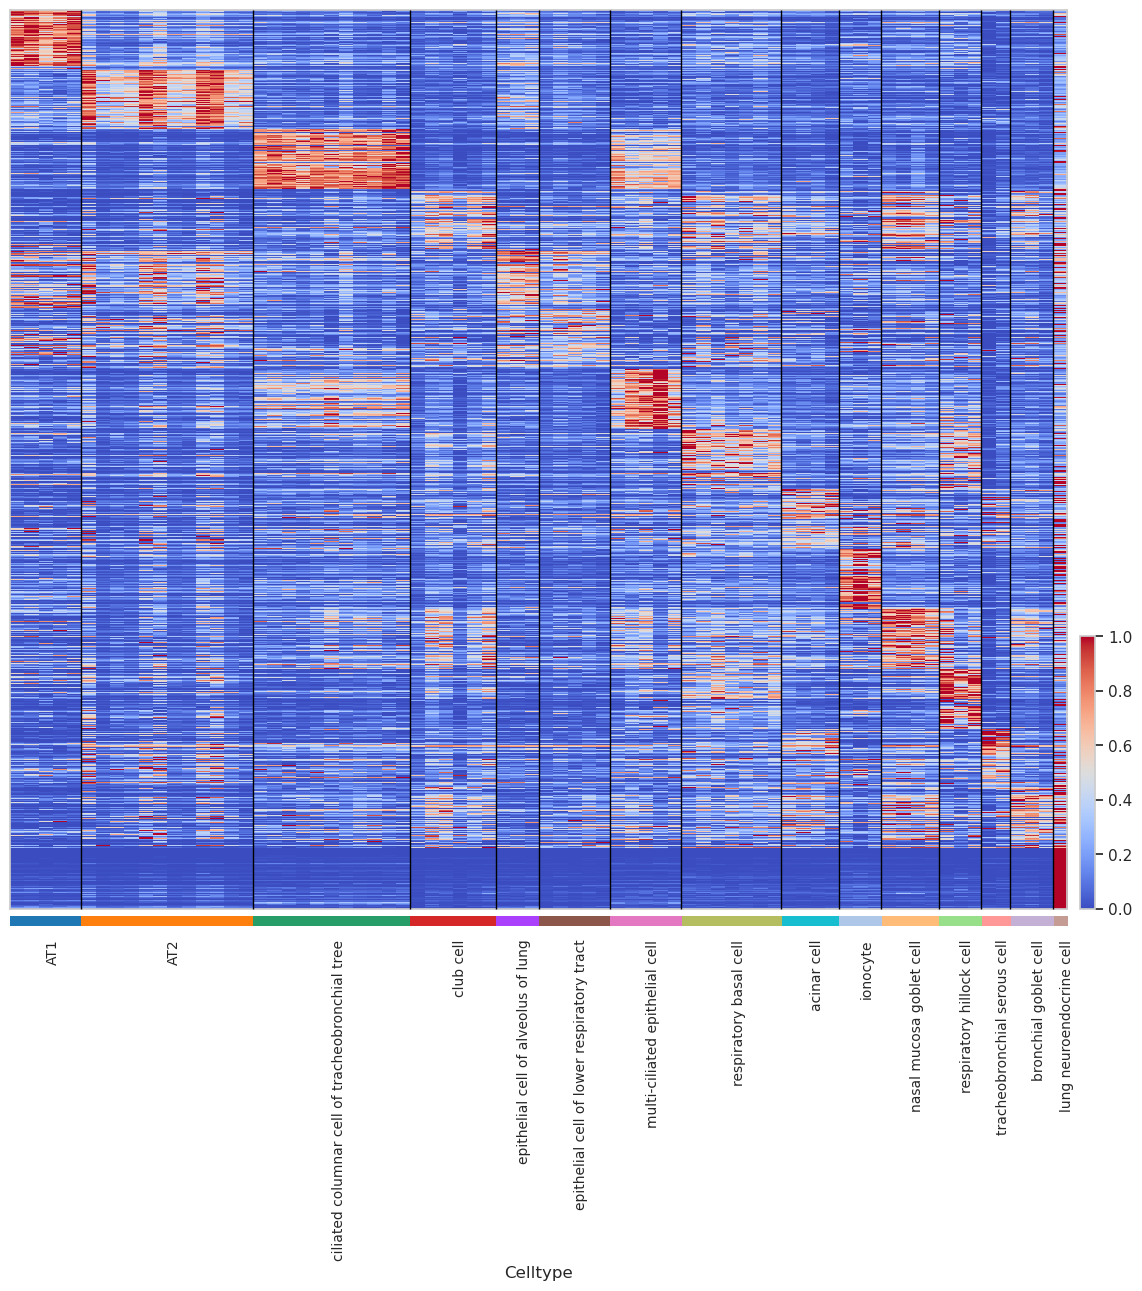

In [116]:
desired_order = [
 'AT1',
 'AT2',
 'ciliated columnar cell of tracheobronchial tree',
 'club cell',
 'epithelial cell of alveolus of lung',
 'epithelial cell of lower respiratory tract',
 'multi-ciliated epithelial cell',
 'respiratory basal cell',
 'acinar cell',
 'ionocyte',
 'nasal mucosa goblet cell',
 'respiratory hillock cell',
 'tracheobronchial serous cell',
 'bronchial goblet cell',
 'lung neuroendocrine cell'
 ]

pseudobulk_no_cancer.obs['Celltype'] = pd.Categorical(
    pseudobulk_no_cancer.obs['Celltype'],
    categories=desired_order,
    ordered=True
)

pseudobulk_no_cancer = pseudobulk_no_cancer[
    pseudobulk_no_cancer.obs['Celltype'].sort_values().index
].copy()

sc.pp.scale(pseudobulk_no_cancer, zero_center=True, max_value=10)

pseudobulk_no_cancer.obs['order'] = pseudobulk_no_cancer.obs['Celltype'].cat.codes
pseudobulk_no_cancer = pseudobulk_no_cancer[pseudobulk_no_cancer.obs['order'].sort_values().index].copy()

sc.pl.heatmap(
    pseudobulk_no_cancer,
    var_names=all_markers,
    groupby='Celltype',
    figsize=(14, 12),
    cmap='coolwarm',
    dendrogram=False,
    swap_axes=True,
    use_raw=False,
    standard_scale='var'
)

In [87]:
adata_markers = adata_pseudobulk_filtered[:, adata_pseudobulk_filtered.var_names.isin(all_markers)].copy()

# Проверяем результат
print(f"Original shape: {adata_pseudobulk_filtered.shape}")
print(f"Filtered shape: {adata_pseudobulk_filtered.shape}")
print(f"Genes in filtered object: {adata_pseudobulk_filtered.var_names.tolist()}")

Original shape: (162, 7000)
Filtered shape: (162, 7000)
Genes in filtered object: ['KANK2', 'NUP93', 'TMPRSS4', 'SERPINH1', 'PLAU', 'CBLL1', 'EHHADH', 'DDIT3', 'MGLL', 'EPSTI1', 'UBE3D', 'ERBB3', 'MIIP', 'TMUB2', 'RGS17', 'S100PBP', 'SPNS2', 'ZNF182', 'SYCP2', 'CHD2', 'CHST12', 'NT5C3A', 'KCNK6', 'PPP6R1', 'CUEDC1', 'ZNF358', 'PPP1R10', 'UBA7', 'ADAM17', 'NINJ2', 'TTPAL', 'FAM217B', 'MCM2', 'CXCL6', 'HMGB2', 'TFAP2A', 'PTRH1', 'CASP1', 'S100A16', 'MACC1', 'ADH1C', 'ZNF516', 'OARD1', 'TRDMT1', 'JDP2', 'RNF146', 'KRT17', 'MACF1', 'ACOT7', 'MPPE1', 'ASH1L', 'ALDH1A1', 'EXOC4', 'PRRC2A', 'TRNP1', 'MST1', 'GAS8', 'IPO9', 'KDM1B', 'UBE2G2', 'NFKBIZ', 'LPGAT1', 'S100A13', 'UBE2W', 'PI4KB', 'HSD17B1', 'PPP1R16A', 'TAF3', 'LETM2', 'KDF1', 'ZDHHC6', 'SPSB3', 'ARL6IP6', 'CLPX', 'SLFN13', 'CCL3', 'RAP2A', 'IPMK', 'CASP8', 'LYAR', 'LAMA3', 'FNIP2', 'LRRC4', 'DXO', 'MYEF2', 'CCDC171', 'ACCS', 'LRRC56', 'SNX29', 'METTL16', 'STAT5B', 'TRIP4', 'RUFY2', 'ZNF584', 'ANXA6', 'SBF2', 'NUP160', 'CCDC74B', 'D

In [ ]:
distance_matrix = cdist(adata_markers.X, adata_markers.X, metric='braycurtis')
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pcoa_coordinates = mds.fit_transform(distance_matrix)

adata_markers.obsm['X_pcoa'] = pcoa_coordinates

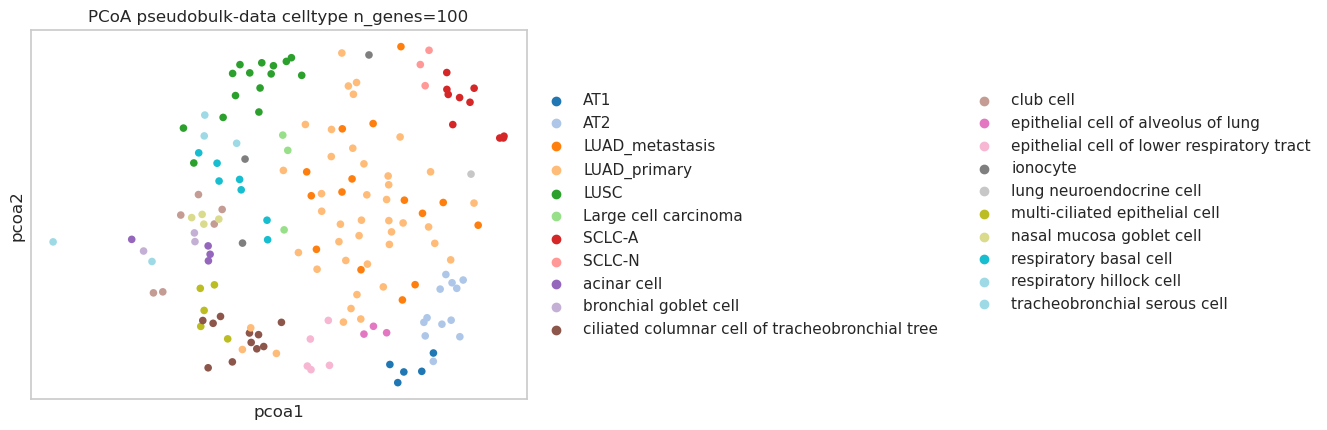

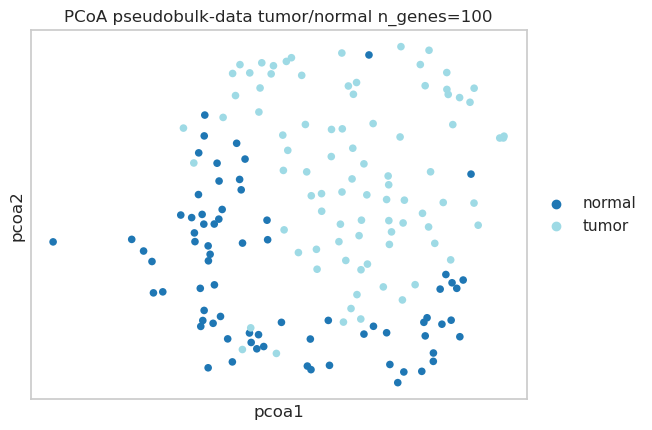

In [115]:
sc.pl.embedding(
    adata_markers,
    basis="pcoa",
    title="PCoA pseudobulk-data celltype n_genes=100", 
    color="Celltype", 
    size=120, 
    palette="tab20"
)

sc.pl.embedding(
    adata_markers,
    basis="pcoa",
    title="PCoA pseudobulk-data tumor/normal n_genes=100", 
    color="cnv_status", 
    size=120, 
    palette="tab20"
)

### PCoA based on top-50 genes

In [ ]:
pseudobulk_no_cancer = pseudobulk_no_cancer[~pseudobulk_no_cancer.obs['Celltype'].isin(["lung neuroendocrine cell"])].copy()

In [ ]:
sc.tl.rank_genes_groups(pseudobulk_no_cancer, groupby='Celltype', method='wilcoxon', n_genes=100)

In [ ]:
all_markers = []
for ct in pseudobulk_no_cancer.obs['Celltype'].unique():
    markers = sc.get.rank_genes_groups_df(pseudobulk_no_cancer, group=ct).head(50)['names'].tolist()
    all_markers.extend(markers)

In [ ]:
all_markers.extend(lnc_top100)

In [108]:
len(all_markers)

1500

In [109]:
desired_order = pseudobulk_no_cancer.obs['Celltype'].unique().to_list()
desired_order

['AT1',
 'AT2',
 'ciliated columnar cell of tracheobronchial tree',
 'club cell',
 'epithelial cell of alveolus of lung',
 'epithelial cell of lower respiratory tract',
 'multi-ciliated epithelial cell',
 'respiratory basal cell',
 'acinar cell',
 'ionocyte',
 'nasal mucosa goblet cell',
 'respiratory hillock cell',
 'tracheobronchial serous cell',
 'bronchial goblet cell']

In [ ]:
pseudobulk_no_cancer = sc.concat([pseudobulk_no_cancer, adata_neuro_pseudobulk])

... storing 'dataset' as categorical
... storing 'cnv_status' as categorical


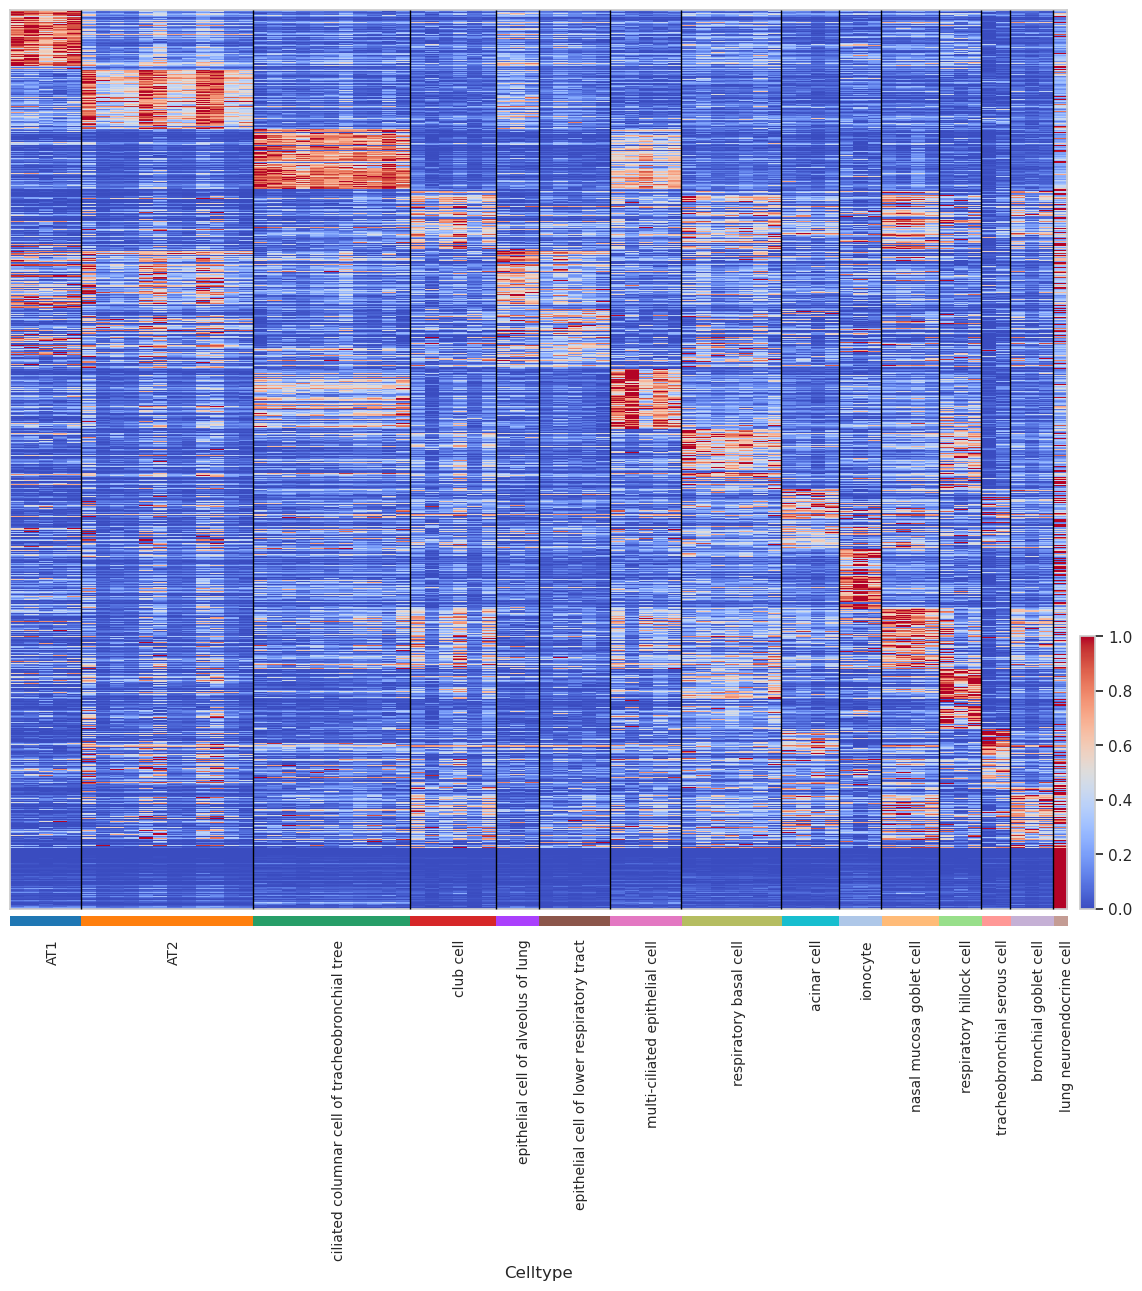

In [111]:
desired_order = [
 'AT1',
 'AT2',
 'ciliated columnar cell of tracheobronchial tree',
 'club cell',
 'epithelial cell of alveolus of lung',
 'epithelial cell of lower respiratory tract',
 'multi-ciliated epithelial cell',
 'respiratory basal cell',
 'acinar cell',
 'ionocyte',
 'nasal mucosa goblet cell',
 'respiratory hillock cell',
 'tracheobronchial serous cell',
 'bronchial goblet cell',
 "lung neuroendocrine cell"
 ]

pseudobulk_no_cancer.obs['Celltype'] = pd.Categorical(
    pseudobulk_no_cancer.obs['Celltype'],
    categories=desired_order,
    ordered=True
)

pseudobulk_no_cancer = pseudobulk_no_cancer[
    pseudobulk_no_cancer.obs['Celltype'].sort_values().index
].copy()

sc.pp.scale(pseudobulk_no_cancer, zero_center=True, max_value=10)

pseudobulk_no_cancer.obs['order'] = pseudobulk_no_cancer.obs['Celltype'].cat.codes
pseudobulk_no_cancer = pseudobulk_no_cancer[pseudobulk_no_cancer.obs['order'].sort_values().index].copy()

sc.pl.heatmap(
    pseudobulk_no_cancer,
    var_names=all_markers,
    groupby='Celltype',
    figsize=(14, 12),
    cmap='coolwarm',
    dendrogram=False,
    swap_axes=True,
    use_raw=False,
    standard_scale='var'
)

In [112]:
adata_markers = adata_pseudobulk_filtered[:, adata_pseudobulk_filtered.var_names.isin(all_markers)].copy()

# Проверяем результат
print(f"Original shape: {adata_pseudobulk_filtered.shape}")
print(f"Filtered shape: {adata_pseudobulk_filtered.shape}")
print(f"Genes in filtered object: {adata_pseudobulk_filtered.var_names.tolist()}")

Original shape: (162, 7000)
Filtered shape: (162, 7000)
Genes in filtered object: ['KANK2', 'NUP93', 'TMPRSS4', 'SERPINH1', 'PLAU', 'CBLL1', 'EHHADH', 'DDIT3', 'MGLL', 'EPSTI1', 'UBE3D', 'ERBB3', 'MIIP', 'TMUB2', 'RGS17', 'S100PBP', 'SPNS2', 'ZNF182', 'SYCP2', 'CHD2', 'CHST12', 'NT5C3A', 'KCNK6', 'PPP6R1', 'CUEDC1', 'ZNF358', 'PPP1R10', 'UBA7', 'ADAM17', 'NINJ2', 'TTPAL', 'FAM217B', 'MCM2', 'CXCL6', 'HMGB2', 'TFAP2A', 'PTRH1', 'CASP1', 'S100A16', 'MACC1', 'ADH1C', 'ZNF516', 'OARD1', 'TRDMT1', 'JDP2', 'RNF146', 'KRT17', 'MACF1', 'ACOT7', 'MPPE1', 'ASH1L', 'ALDH1A1', 'EXOC4', 'PRRC2A', 'TRNP1', 'MST1', 'GAS8', 'IPO9', 'KDM1B', 'UBE2G2', 'NFKBIZ', 'LPGAT1', 'S100A13', 'UBE2W', 'PI4KB', 'HSD17B1', 'PPP1R16A', 'TAF3', 'LETM2', 'KDF1', 'ZDHHC6', 'SPSB3', 'ARL6IP6', 'CLPX', 'SLFN13', 'CCL3', 'RAP2A', 'IPMK', 'CASP8', 'LYAR', 'LAMA3', 'FNIP2', 'LRRC4', 'DXO', 'MYEF2', 'CCDC171', 'ACCS', 'LRRC56', 'SNX29', 'METTL16', 'STAT5B', 'TRIP4', 'RUFY2', 'ZNF584', 'ANXA6', 'SBF2', 'NUP160', 'CCDC74B', 'D

In [ ]:
distance_matrix = cdist(adata_markers.X, adata_markers.X, metric='braycurtis')
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pcoa_coordinates = mds.fit_transform(distance_matrix)

adata_markers.obsm['X_pcoa'] = pcoa_coordinates

... storing 'Celltype' as categorical
... storing 'dataset' as categorical
... storing 'cnv_status' as categorical


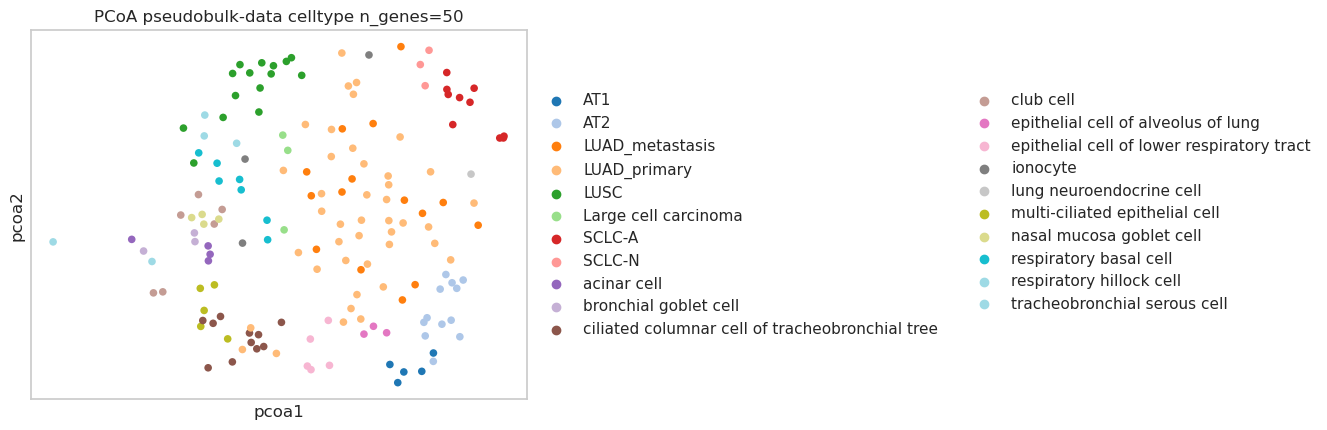

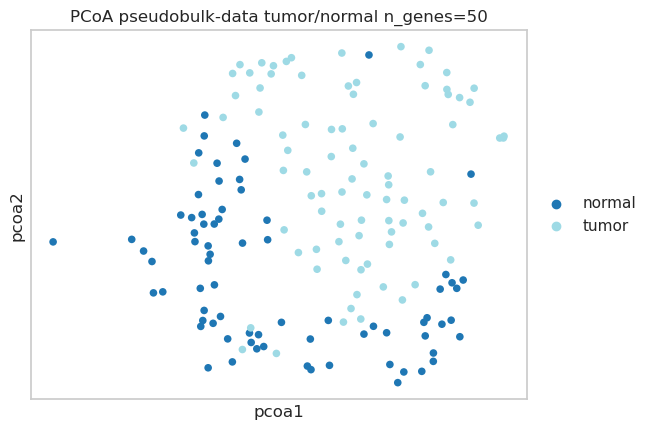

In [114]:
sc.pl.embedding(
    adata_markers,
    basis="pcoa",
    title="PCoA pseudobulk-data celltype n_genes=50", 
    color="Celltype", 
    size=120, 
    palette="tab20"
)

sc.pl.embedding(
    adata_markers,
    basis="pcoa",
    title="PCoA pseudobulk-data tumor/normal n_genes=50", 
    color="cnv_status", 
    size=120, 
    palette="tab20"
)